In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import importlib
import joblib
import itertools
import torch

from sklearn.feature_selection import mutual_info_regression, SelectFromModel, RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedKFold)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.neural_network import MLPClassifier
from tabpfn import TabPFNClassifier
from joblib import Parallel, delayed
import shutil


In [2]:
# Fetch all ratings across all bike groups


rated_bikes_df = pd.read_csv('ratings/combined_clean_ratings.csv')

print(rated_bikes_df.head())

print(rated_bikes_df.shape)


   Unnamed: 0                                   uid   bid  rating
0           0  06f6a6fb-e5b0-49b1-8fa2-37521a357b97  4178       0
1           1  06f6a6fb-e5b0-49b1-8fa2-37521a357b97  1285       0
2           2  06f6a6fb-e5b0-49b1-8fa2-37521a357b97  4600       0
3           3  06f6a6fb-e5b0-49b1-8fa2-37521a357b97   714       0
4           4  06f6a6fb-e5b0-49b1-8fa2-37521a357b97  2635       0
(10350, 4)


In [3]:
visual_df =pd.read_csv("../Data/clip_sBIKED_reduced.csv", index_col=0)
print(f"######## Original dataset #########")
column_types = visual_df.dtypes
type_counts = column_types.value_counts()
print(type_counts,"\n")

object_columns = visual_df.select_dtypes(include=['object']).columns
print("Object columns:", object_columns.to_list(), "\n")


print(f'Number of columns: {len(visual_df.columns)}' , "\n")

columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
visual_df = visual_df.loc[:, (visual_df != visual_df.iloc[0]).any()]

print(f"######## Converted dataset #########")
column_types = visual_df.dtypes
type_counts = column_types.value_counts()
print(type_counts, "\n")
print(f'Number of columns after removing constants: {len(visual_df.columns)}')


all_my_bikes_df = visual_df.loc[rated_bikes_df['bid'].unique()]

######## Original dataset #########
float64    47
int64      13
bool        8
object      3
Name: count, dtype: int64 

Object columns: ['MATERIAL', 'RIM_STYLE front', 'RIM_STYLE rear'] 

Number of columns: 71 

######## Converted dataset #########
float64    43
int64      10
int32       8
Name: count, dtype: int64 

Number of columns after removing constants: 61


In [8]:
# Fetch meaningfull bikes 

threshold_usable = 0.7
threshold_unusable = 1- threshold_usable

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings >= threshold_usable].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings <= threshold_unusable].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

# Correlation and Mutual Information

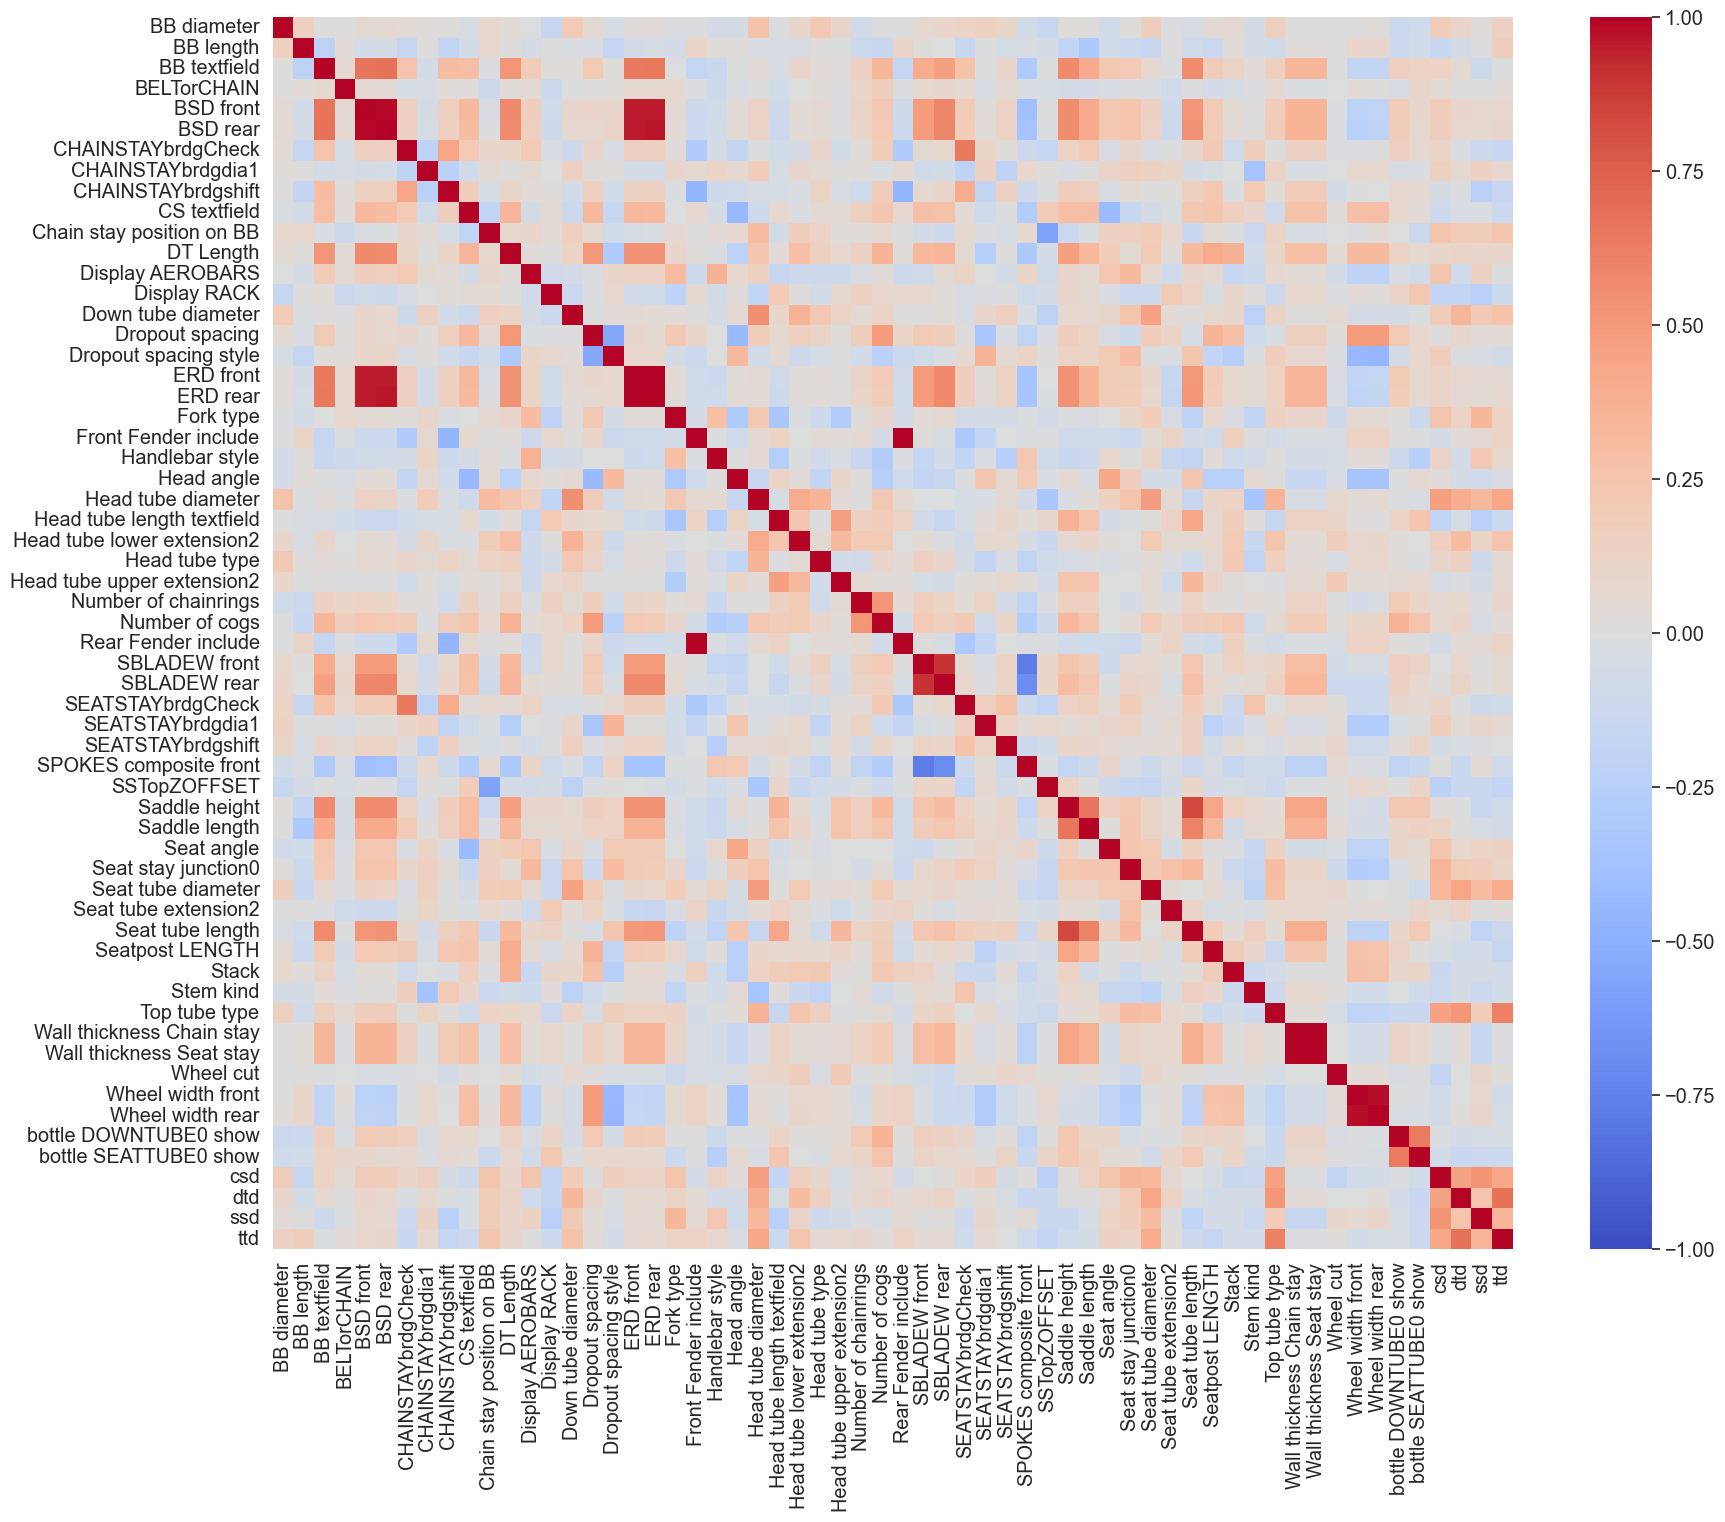

In [23]:
non_constant_rated_df = all_my_bikes_df.loc[:, (all_my_bikes_df != all_my_bikes_df.iloc[0]).any()]
correlation_matrix = non_constant_rated_df.corr()
sns.set(font_scale=1.3)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
plt.savefig('parameter_correlation.svg', format='svg')
plt.show()

In [13]:
# # Threshold for high correlation
# high_corr_threshold = 0.9

# # Step 1: Compute the correlation matrix of non-constant rated features
# non_constant_rated_df = all_my_bikes_df.loc[:, (all_my_bikes_df != all_my_bikes_df.iloc[0]).any()]
# correlation_matrix = non_constant_rated_df.corr()

# # Step 2: Identify highly correlated feature pairs
# # We take the upper triangle of the correlation matrix to avoid duplicates
# upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# # Find features that have a correlation higher than the threshold
# high_corr_pairs = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > high_corr_threshold)]

# # Step 3: Drop one feature from each pair of highly correlated features
# # We drop features that appear in the high_corr_pairs list
# reduced_df = non_constant_rated_df.drop(columns=high_corr_pairs)
# columns_to_keep = reduced_df.columns.intersection(meaningfull_bikes_df.columns)
# meaningfull_bikes_df = meaningfull_bikes_df[columns_to_keep]
# meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)
# print(meaningfull_bikes_df.shape)


# # Step 4: Visualize the reduced correlation matrix
# reduced_correlation_matrix = reduced_df.corr()

# # Plot heatmap for reduced features
# sns.set(font_scale=1.3)
# plt.figure(figsize=(20, 16))
# sns.heatmap(reduced_correlation_matrix, cmap='coolwarm')
# plt.show()


## Usable

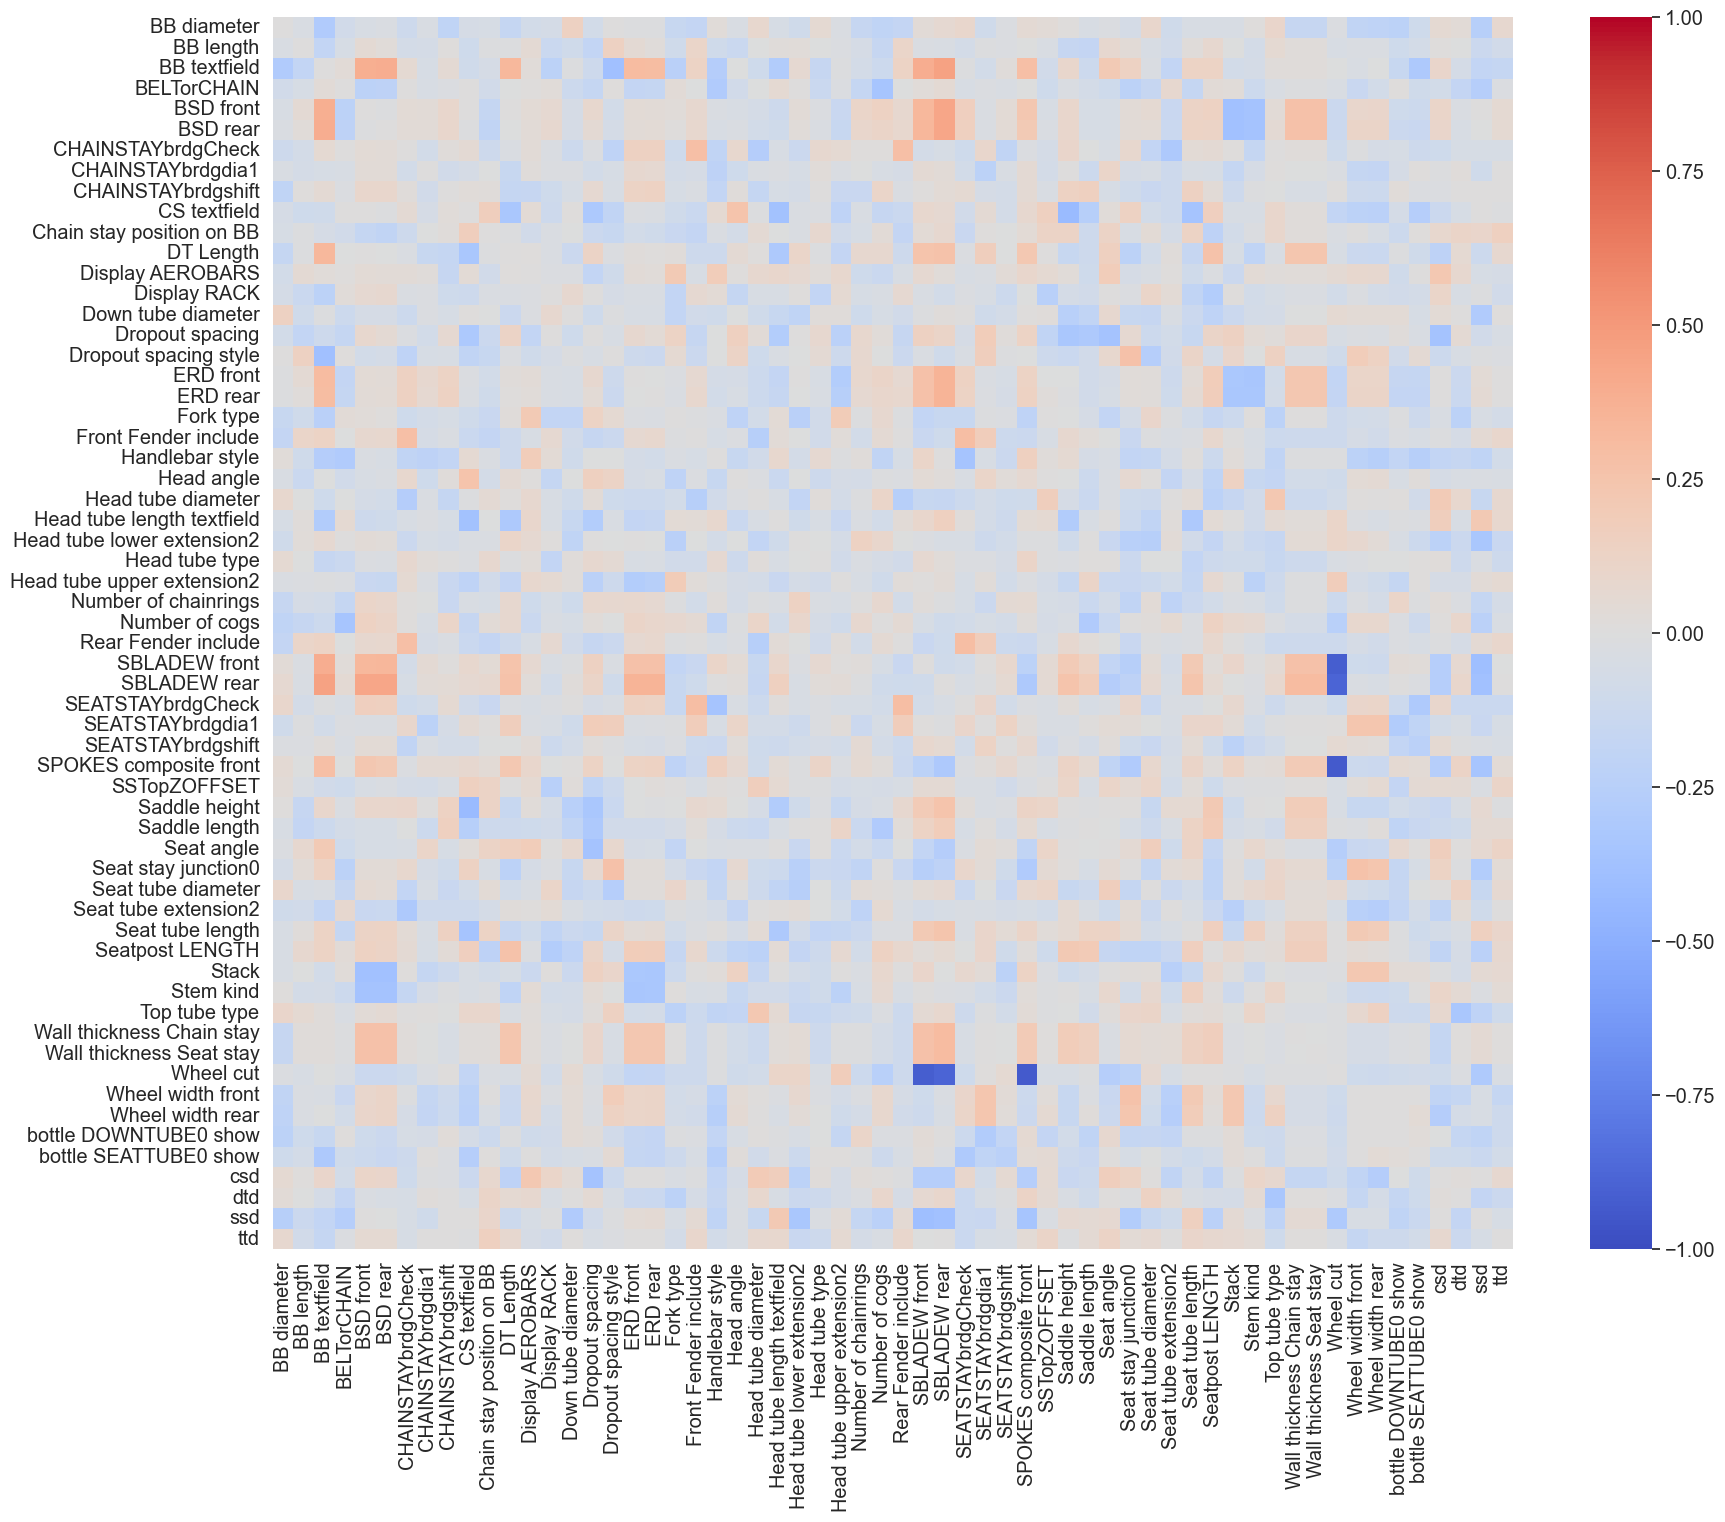

In [21]:

non_constant_usable = usable_bikes.loc[:, (usable_bikes != usable_bikes.iloc[0]).any()]
non_constant_all = all_my_bikes_df.loc[:, (all_my_bikes_df != all_my_bikes_df.iloc[0]).any()]

correlation_matrix_usable = non_constant_usable.corr()
correlation_matrix_all = non_constant_all.corr()

correlation_matrix = abs(correlation_matrix_all) - abs(correlation_matrix_usable)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
plt.savefig('usable_corr.svg', format='svg')

plt.show()

60


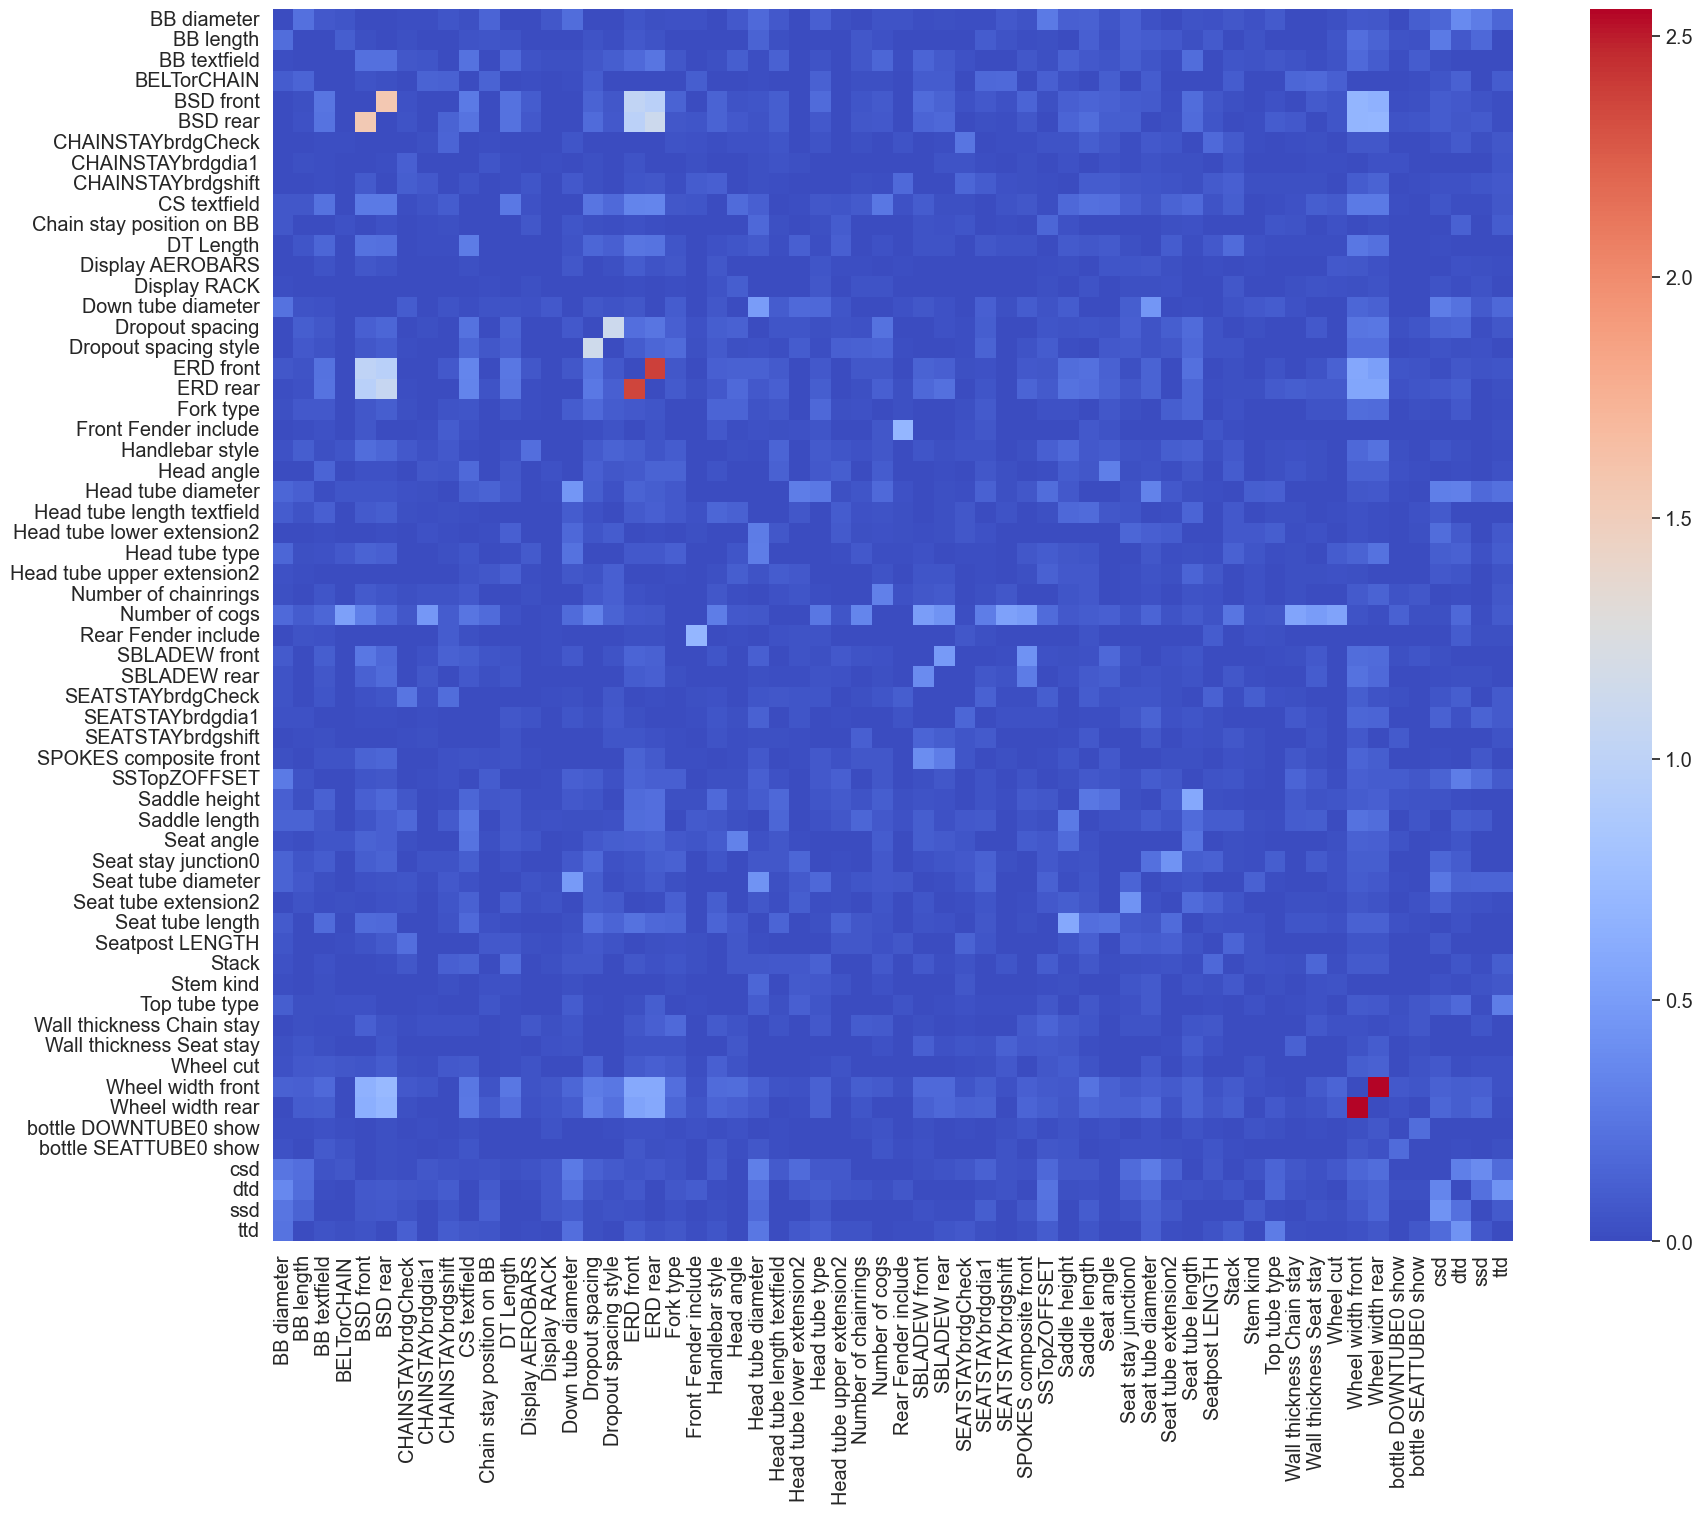

In [20]:
# Mutual information in parameter space

non_constant_df = all_my_bikes_df.loc[:, (all_my_bikes_df != all_my_bikes_df.iloc[0]).any()]

# non_constant_df = usable_bikes.loc[:, (usable_bikes != usable_bikes.iloc[0]).any()]
print(len(non_constant_df.columns))
keywords = ['Display','Check','show','include','Number', 'or', 'style', 'type', 'kind']
columns_with_keywords = [col for col in non_constant_df.columns if any(keyword in col for keyword in keywords)]
column_indices = [non_constant_df.columns.get_loc(col) for col in columns_with_keywords]

mi_matrix = pd.DataFrame(index=non_constant_df.columns, columns=non_constant_df.columns)

for col_x in non_constant_df.columns:
    for col_y in non_constant_df.columns:
        if col_x != col_y:
            discrete_features = [non_constant_df.columns.get_loc(col_x) in column_indices]
            mi_matrix.loc[col_x, col_y] = mutual_info_regression(
                non_constant_df[[col_x]], non_constant_df[col_y],
                discrete_features=discrete_features
            )[0]

np.fill_diagonal(mi_matrix.values, 0)
mi_matrix = mi_matrix.astype('float')

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 16))
sns.heatmap(mi_matrix, cmap='coolwarm')
plt.savefig('parameter_mutual.svg', format='svg')

# plt.title('Mutual Information Matrix')
plt.show()

## Unusable

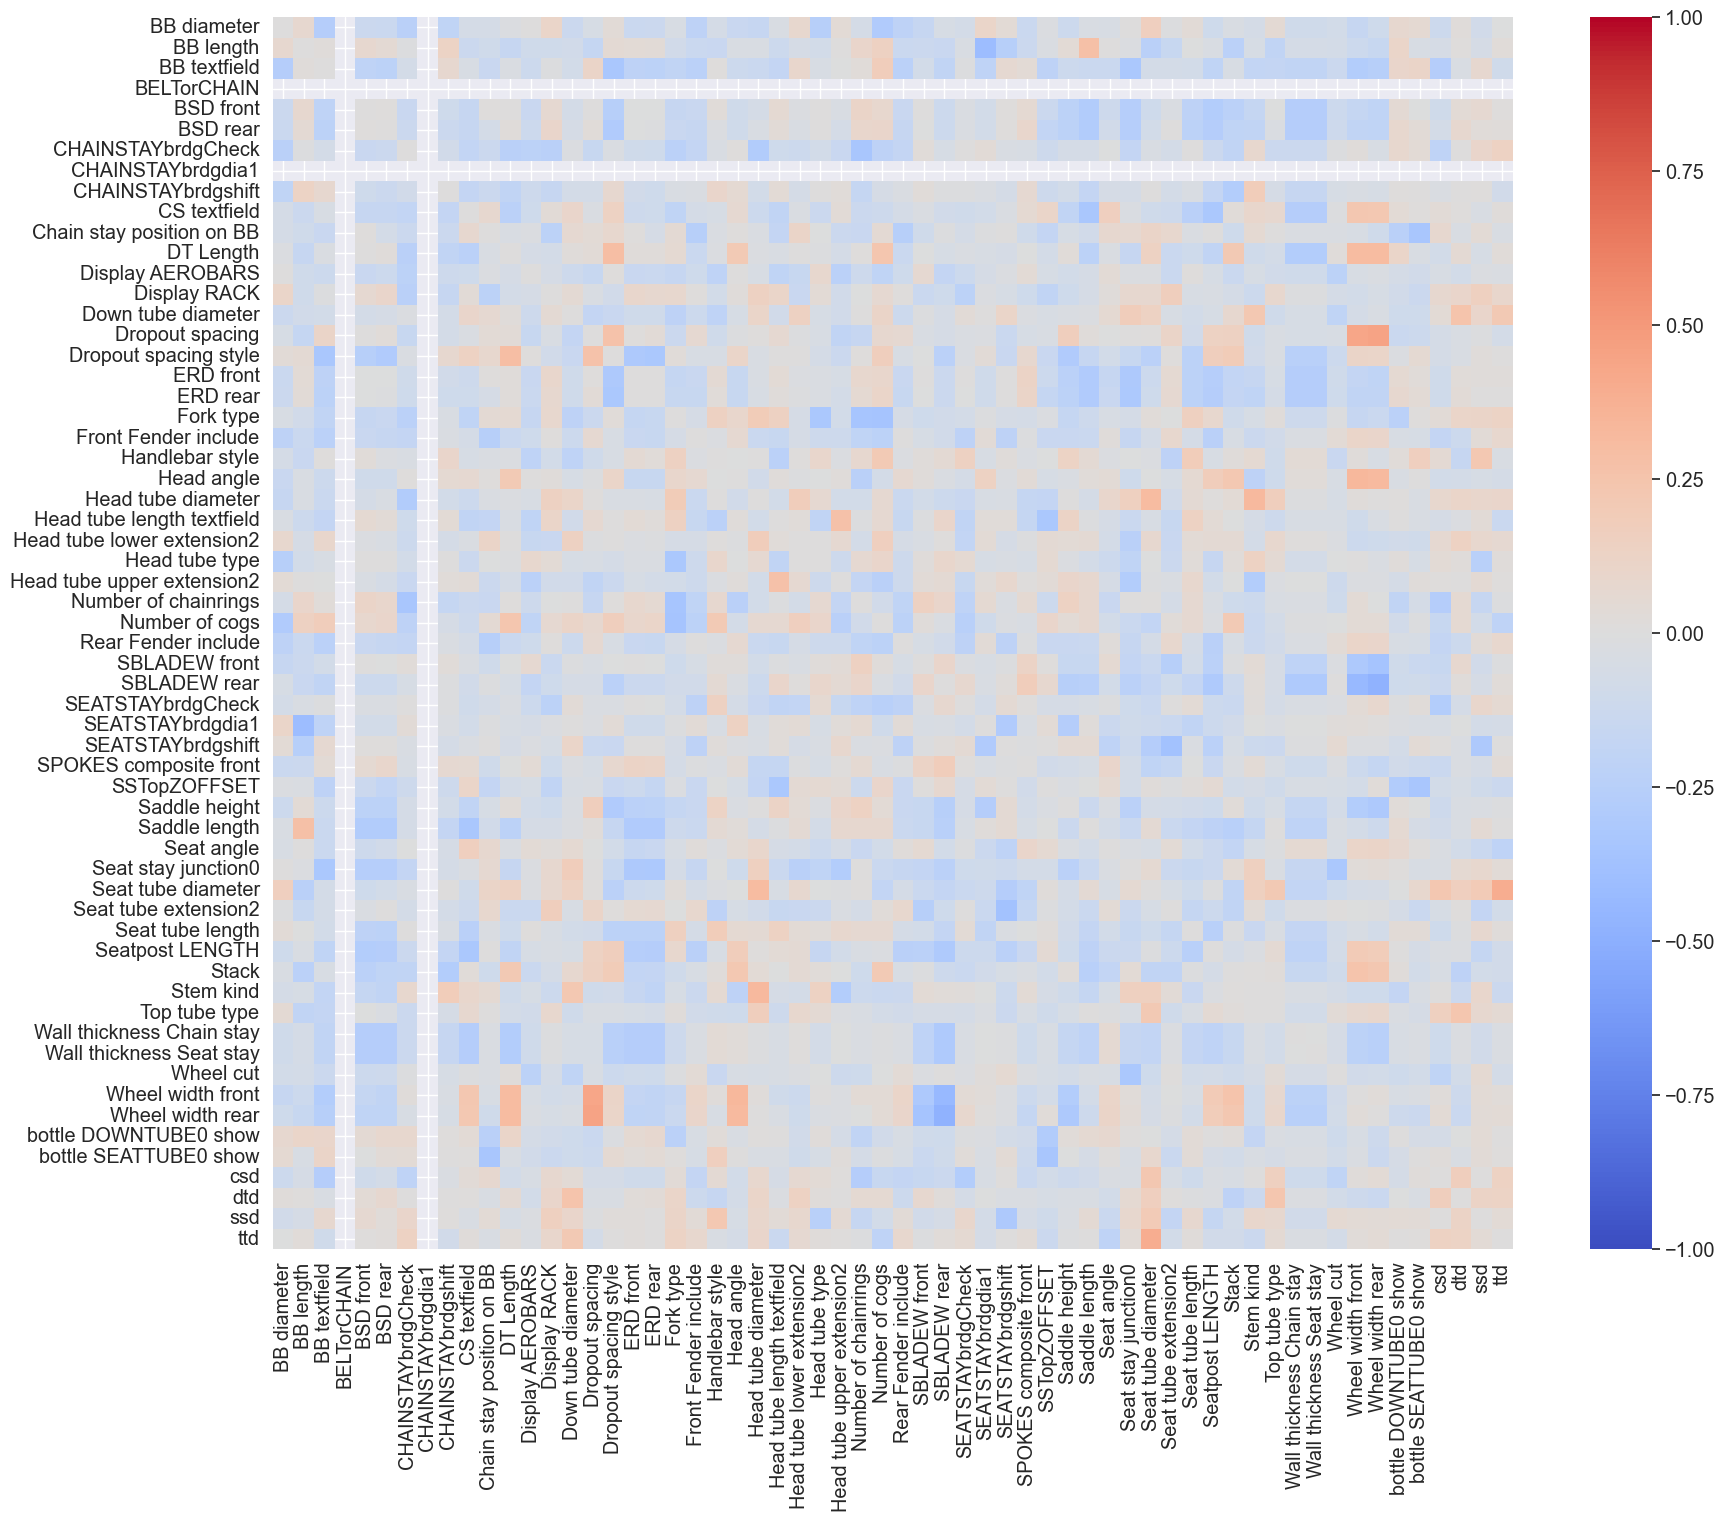

In [22]:

non_constant_unusable = unusable_bikes.loc[:, (unusable_bikes != unusable_bikes.iloc[0]).any()]
non_constant_all = all_my_bikes_df.loc[:, (all_my_bikes_df != all_my_bikes_df.iloc[0]).any()]

correlation_matrix_unusable = non_constant_unusable.corr()
correlation_matrix_all = non_constant_all.corr()

correlation_matrix = abs(correlation_matrix_all) - abs(correlation_matrix_unusable)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
plt.savefig('unusable_corr.svg', format='svg')
plt.show()

# Feature Interactions

### Split data: Split data into training and testing sets (80% training, 20% testing)


In [25]:
y = meaningfull_bikes_df['usable']
X = meaningfull_bikes_df.drop(columns=['usable'])

input_folder = 'datasets'

X_test = pd.read_csv(os.path.join(input_folder,'X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(input_folder,'y_test.csv'), index_col=0)['usable']
X_train = pd.read_csv(os.path.join(input_folder,'X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(input_folder, 'y_train.csv'), index_col=0)['usable']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# X_train.to_csv('datasets/X_train.csv', index=True)
# X_test.to_csv('datasets/X_test.csv', index=True)
# y_train.to_csv('datasets/y_train.csv', index=True)
# y_test.to_csv('datasets/y_test.csv', index=True)


## Plots

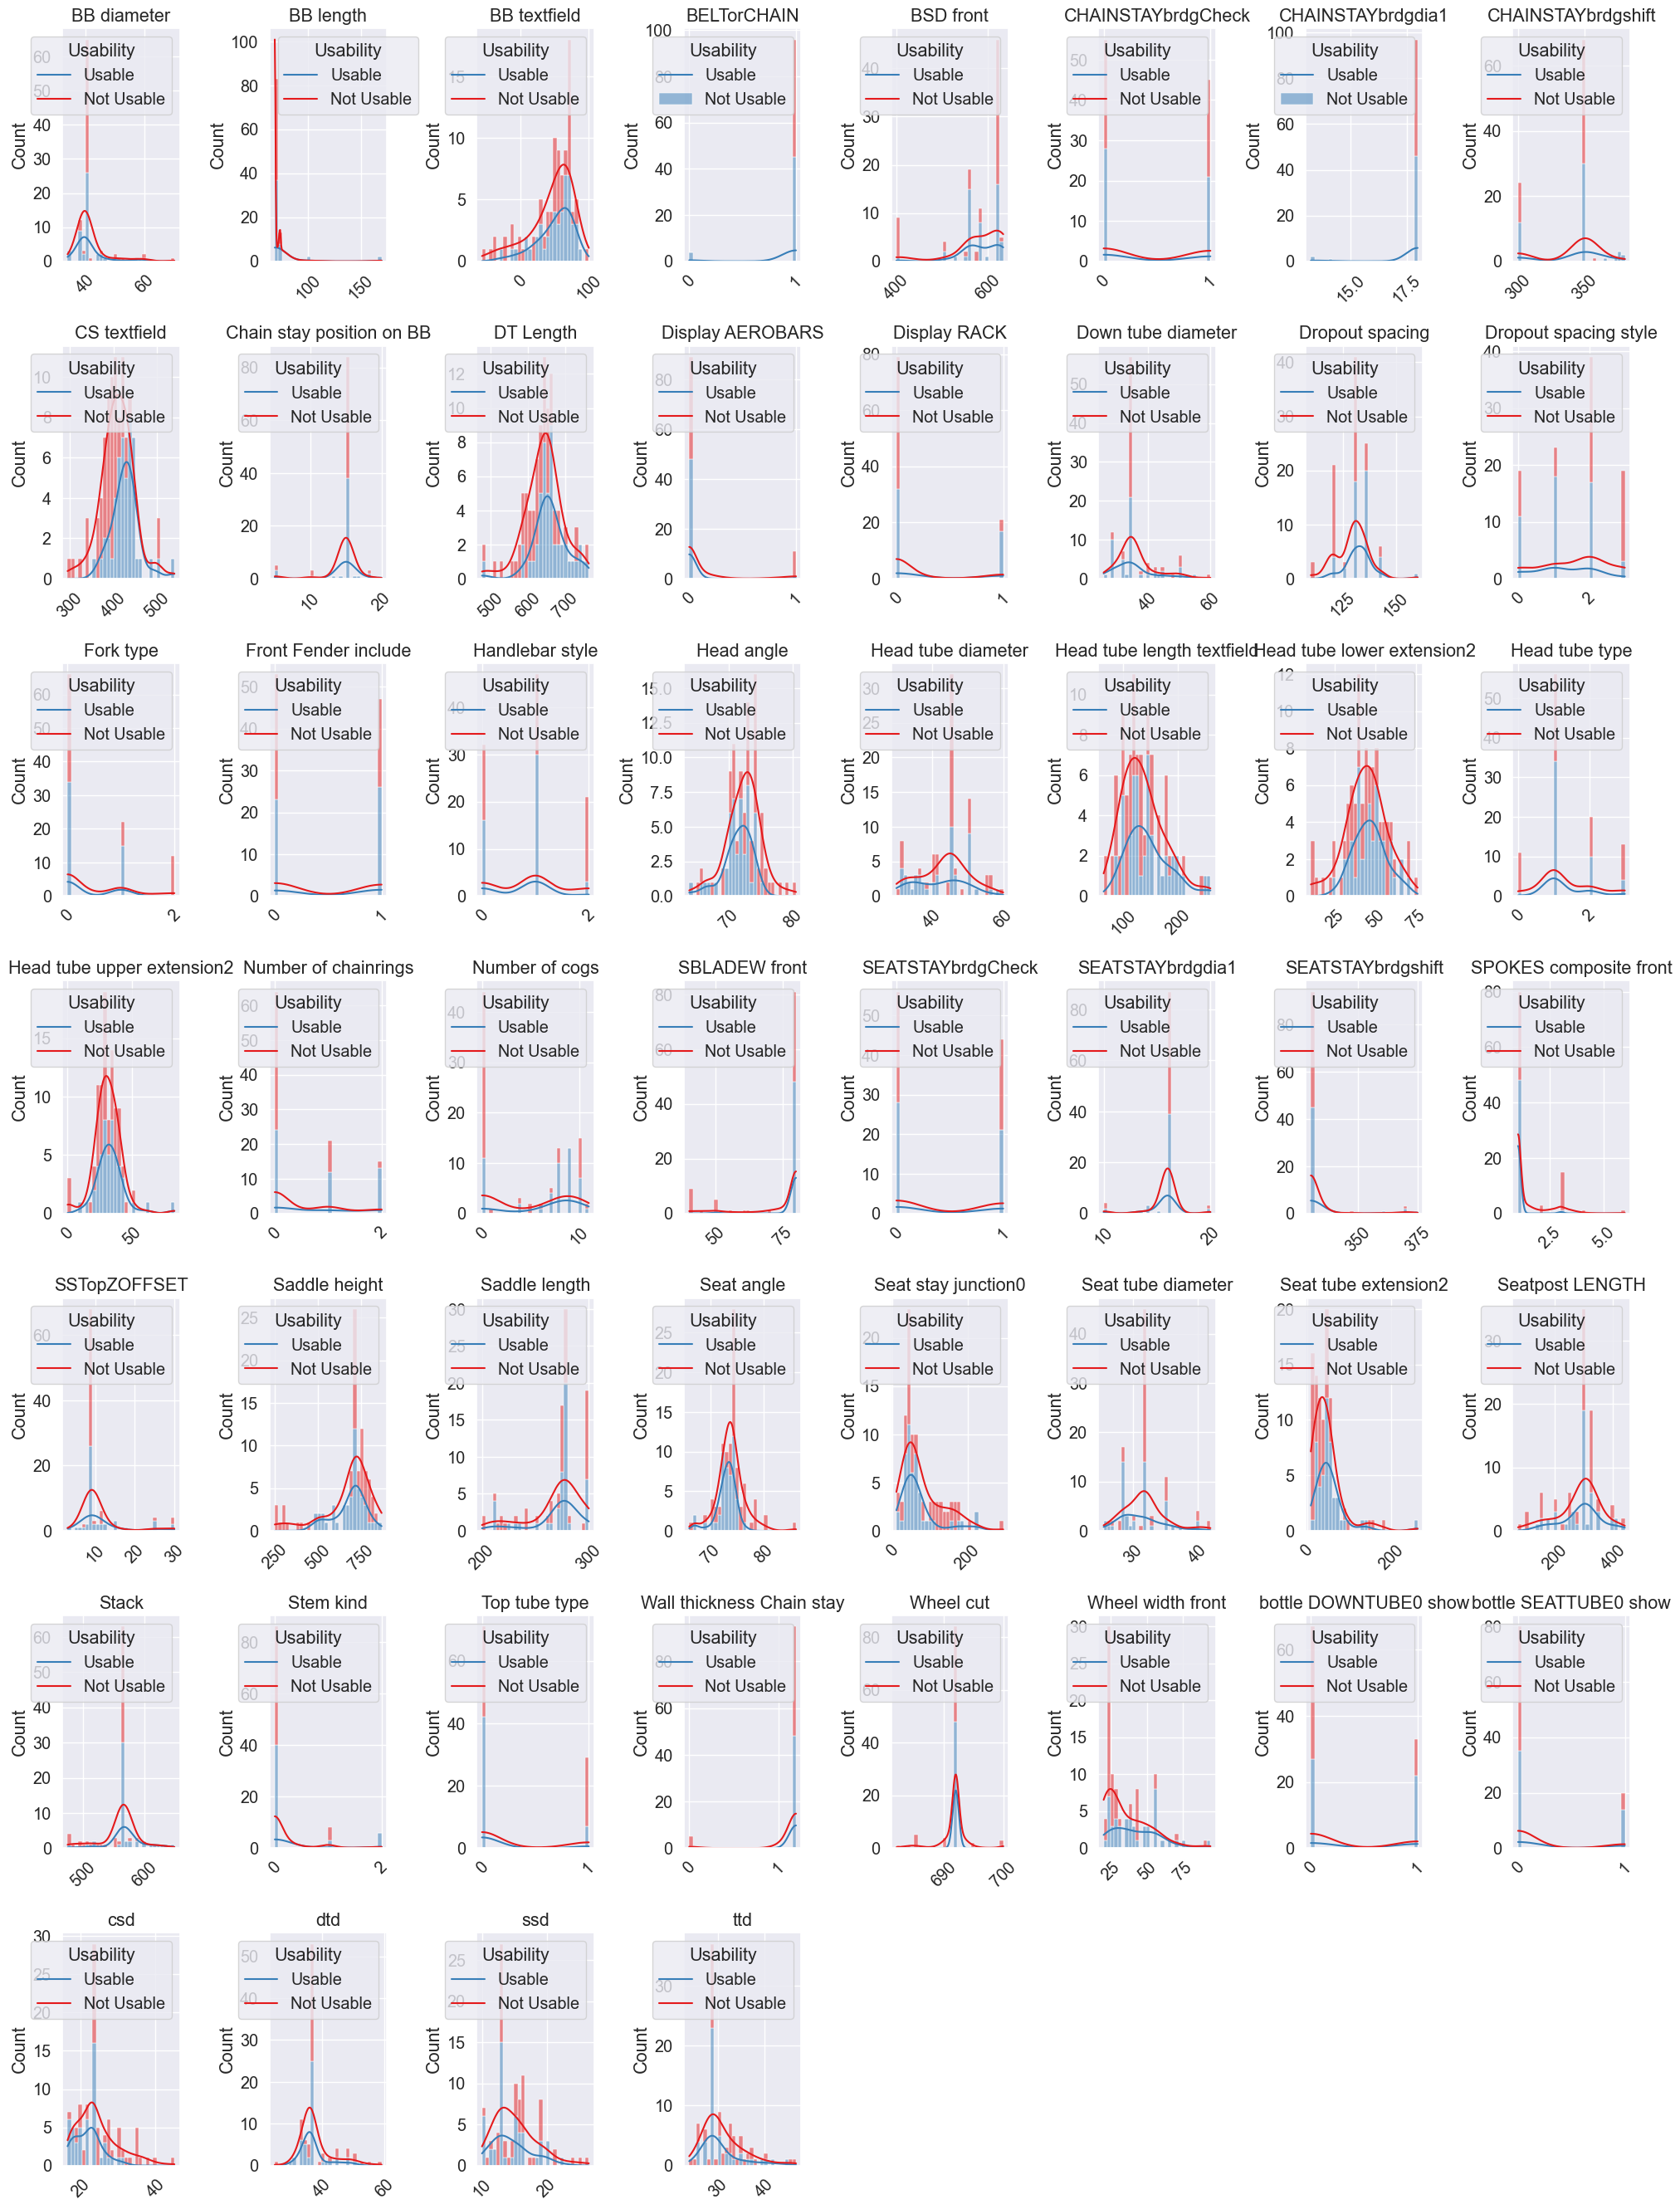

In [16]:
# Drop columns with a single unique value
single_value_columns = meaningfull_bikes_df.columns[meaningfull_bikes_df.nunique() == 1].tolist()
meaningfull_bikes_df_non_const = meaningfull_bikes_df.drop(columns=single_value_columns)

# Select numeric features excluding 'usable'
features = meaningfull_bikes_df_non_const.select_dtypes(include=['number']).columns.tolist()
if 'usable' in features:
    features.remove('usable')  # Remove 'usable' from features to plot

num_features = len(features)
num_cols = 8  # Number of columns in the grid of subplots
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed, rounding up

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Create histograms for each feature, using 'usable' as hue
for i, feature in enumerate(features):
    sns.histplot(data=meaningfull_bikes_df_non_const, x=feature, hue='usable', kde=True, bins=30, 
                 multiple='stack', palette='Set1', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend(title='Usability', labels=['Usable', 'Not Usable'])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Turn off axes for any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('../style_dist.pdf', format='pdf')
plt.show()



## Single decision rule: usable if featue > x else unusable

### Using Decision tree

In [6]:
def show_tree(model, features, target):
    tree_rules = export_text(model, feature_names=features)

    plt.figure(figsize=(20, 10))
    plot_tree(model, feature_names=features, class_names=[str(i) for i in target.unique()], filled=True)
    plt.show()

    print(tree_rules)

                   feature  mean_cross_val_accuracy
8             CS textfield                   0.8000
26          Number of cogs                   0.7125
32  SPOKES composite front                   0.6750
27           SBLADEW front                   0.6500
48   bottle DOWNTUBE0 show                   0.6500
10               DT Length                   0.6500
47       Wheel width front                   0.6375
12            Display RACK                   0.6250
13      Down tube diameter                   0.6250
14         Dropout spacing                   0.6250
Accuracy after refit: 0.79


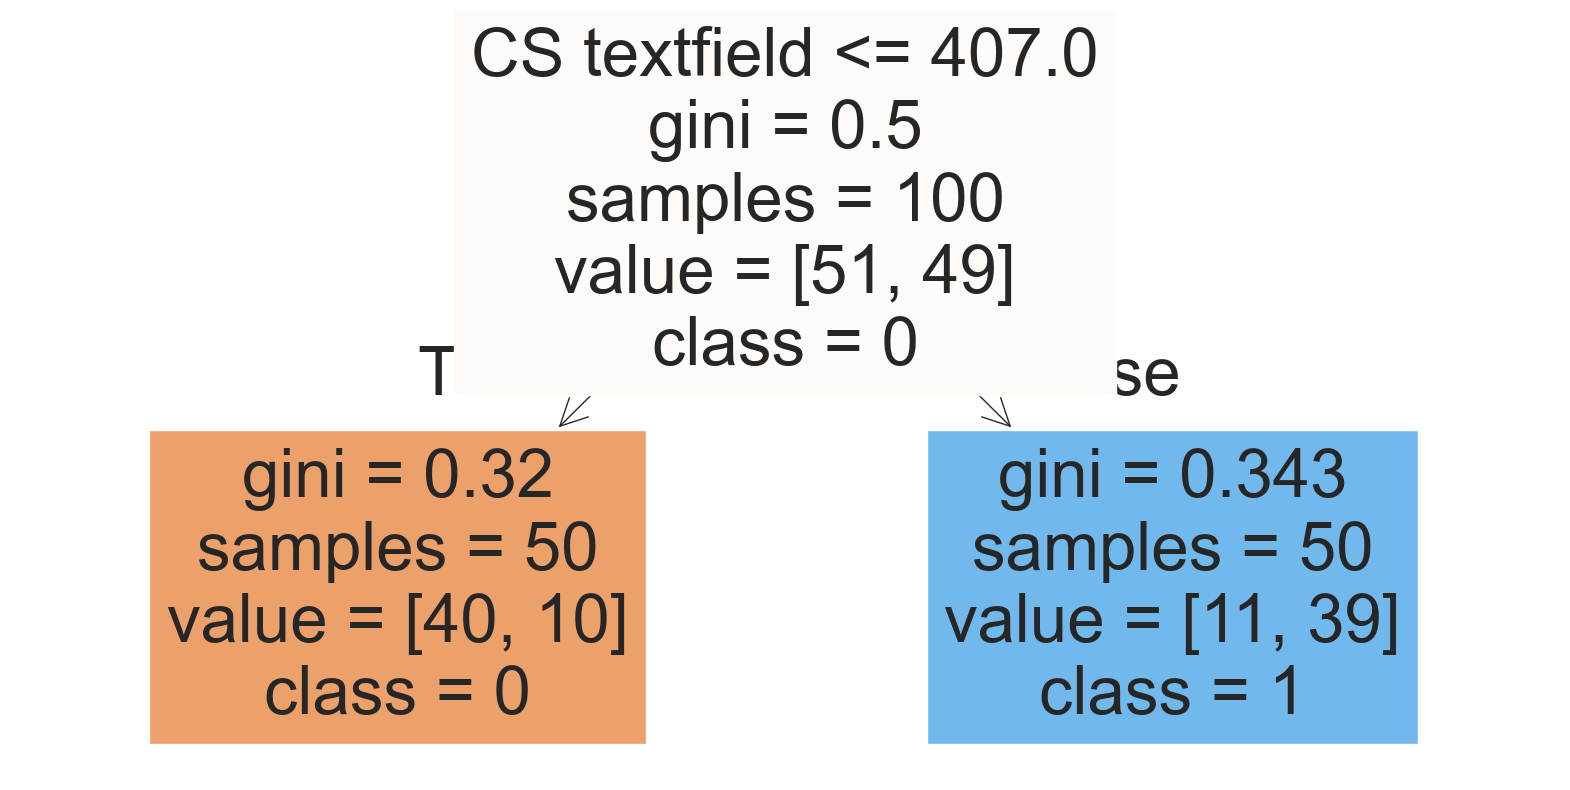

|--- CS textfield <= 407.00
|   |--- class: 0
|--- CS textfield >  407.00
|   |--- class: 1



In [38]:
results = []
best_thresholds = {}
best_acc = -np.inf
best_model = None
best_feat = None

# Define the number of cross-validation folds (e.g., 5-fold CV)
cv_folds = 5

# Loop through each feature in the dataset
for feature in X_train.columns:
    # Use only the current feature for cross-validation
    X_feat = X_train[[feature]]
    
    # Initialize a decision tree classifier with max_depth=1
    clf = DecisionTreeClassifier(max_depth=1)
    
    # Perform cross-validation on the current feature and calculate accuracy for each fold
    val_scores = cross_val_score(clf, X_feat, y_train, cv=cv_folds, scoring='accuracy')
    
    # Calculate the mean validation accuracy across folds
    mean_val_accuracy = val_scores.mean()

    # Track the model with the best cross-validation accuracy
    if mean_val_accuracy > best_acc:
        best_acc = mean_val_accuracy
        best_model = DecisionTreeClassifier(max_depth=1)  # Reinitialize to fit later
        best_feat = feature
        best_model.fit(X[[best_feat]], y)  # Train the model on the entire dataset
    
    # Append the results to the list
    results.append({
        'feature': feature,
        'mean_cross_val_accuracy': mean_val_accuracy,
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Sort by cross-validation accuracy in descending order
results_df = results_df.sort_values(by='mean_cross_val_accuracy', ascending=False)

# Print the top 10 features and their accuracies
top_10_results_df = results_df.head(10)
print(top_10_results_df)

# Convert the top 10 results to a LaTeX table format (optional)
latex_table = top_10_results_df.to_latex(index=False, caption='Top 10 Models by Cross-Validation Accuracy', label='tab:top_models')
# print(latex_table)

y_pred = best_model.predict(X[[best_feat]])
print(f"Accuracy after refit: {accuracy_score(y, y_pred)}" )
# Visualize the decision tree using the best feature (ensure show_tree is defined)
show_tree(best_model, [best_feat], y_train )

### Using SVM

In [15]:
results = []

for feature_pair in itertools.combinations(X_train.columns, 1):
    X_feature = X_train[list(feature_pair)]
    clf = SVC(kernel='linear')
    
    # Using cross-validation to evaluate accuracy
    scores = cross_val_score(clf, X_feature, y_train, cv=5, scoring='accuracy')  # Using 5-fold cross-validation
    accuracy = scores.mean()  # Average accuracy over all folds
    
    results.append({
        'features': feature_pair,
        'accuracy': accuracy,
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='accuracy', ascending=False).head(10)

features  accuracy
9             (CS textfield,)    0.7500
29          (Number of cogs,)    0.7250
16   (Dropout spacing style,)    0.6625
28    (Number of chainrings,)    0.6625
36  (SPOKES composite front,)    0.6500
54        (Wheel width rear,)    0.6500
55   (bottle DOWNTUBE0 show,)    0.6500
31           (SBLADEW front,)    0.6375
22              (Head angle,)    0.6250
13            (Display RACK,)    0.6250

### Two decision rules: 

                                   features  mean_cross_val_accuracy
530  (CS textfield, SPOKES composite front)                 0.871429
513               (CS textfield, Fork type)                 0.857143
525           (CS textfield, SBLADEW front)                 0.857143
551                     (CS textfield, csd)                 0.842857
520          (CS textfield, Head tube type)                 0.842857
553                     (CS textfield, ssd)                 0.828571
552                     (CS textfield, dtd)                 0.828571
534              (CS textfield, Seat angle)                 0.828571
526            (CS textfield, SBLADEW rear)                 0.828571
293                (BSD rear, CS textfield)                 0.828571


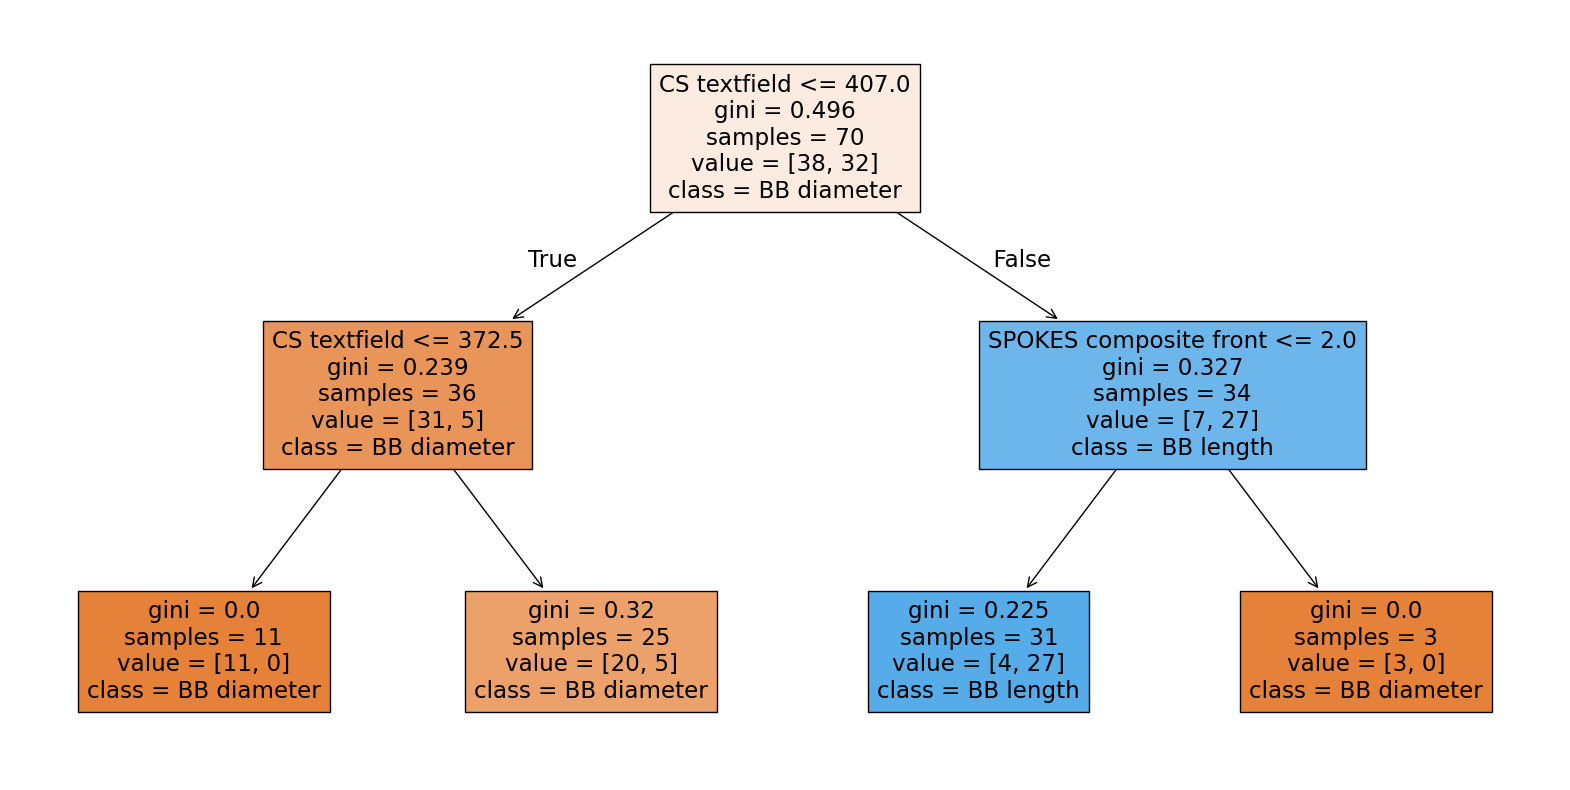

|--- CS textfield <= 407.00
|   |--- CS textfield <= 372.50
|   |   |--- class: 0
|   |--- CS textfield >  372.50
|   |   |--- class: 0
|--- CS textfield >  407.00
|   |--- SPOKES composite front <= 2.00
|   |   |--- class: 1
|   |--- SPOKES composite front >  2.00
|   |   |--- class: 0



In [50]:
results = []
best_acc = -np.inf
best_model = None
best_feat = None
cv_folds = 5  # Number of cross-validation folds

# Loop through each pair of features in the dataset
for feature_pair in itertools.combinations(X_train.columns, 2):
    # Use only the current feature pair for cross-validation
    X_train_feat = X_train[list(feature_pair)]
    
    # Initialize the decision tree classifier
    clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    
    # Perform cross-validation using the selected feature pair
    val_scores = cross_val_score(clf, X_train_feat, y_train, cv=cv_folds, scoring='accuracy')
    
    # Calculate the mean accuracy across the cross-validation folds
    mean_val_accuracy = val_scores.mean()
    
    # Track the model with the best cross-validation accuracy
    if mean_val_accuracy > best_acc:
        best_acc = mean_val_accuracy
        best_model = DecisionTreeClassifier(max_depth=2, random_state=42)  # Reinitialize to fit on entire data
        best_feat = feature_pair
        best_model.fit(X_train_feat, y_train)  # Fit the model on the entire training data using best features

    # Append the results to the list
    results.append({
        'features': feature_pair,
        'mean_cross_val_accuracy': mean_val_accuracy,
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Sort by cross-validation accuracy in descending order
results_df = results_df.sort_values(by='mean_cross_val_accuracy', ascending=False)

# Print the top 10 feature pairs and their accuracies
top_10_results_df = results_df.head(10)
print(top_10_results_df)

# Convert the top 10 results to a LaTeX table format (optional)
latex_table = top_10_results_df.to_latex(index=False, caption='Top 10 Models by Cross-Validation Accuracy', label='tab:top_models')
# print(latex_table)


# Visualize the decision tree using the best feature pair (assuming show_tree is implemented)
show_tree(best_model, best_feat, X.columns)

# save_tree(best_model, 'tree_pair')


### Trees of longer length

Best Accuracy: 0.79
Best Depth: 1
Final Model Accuracy on Full Data: 0.79
Decision Tree Rules:
|--- CS textfield <= 407.00
|   |--- class: 0
|--- CS textfield >  407.00
|   |--- class: 1



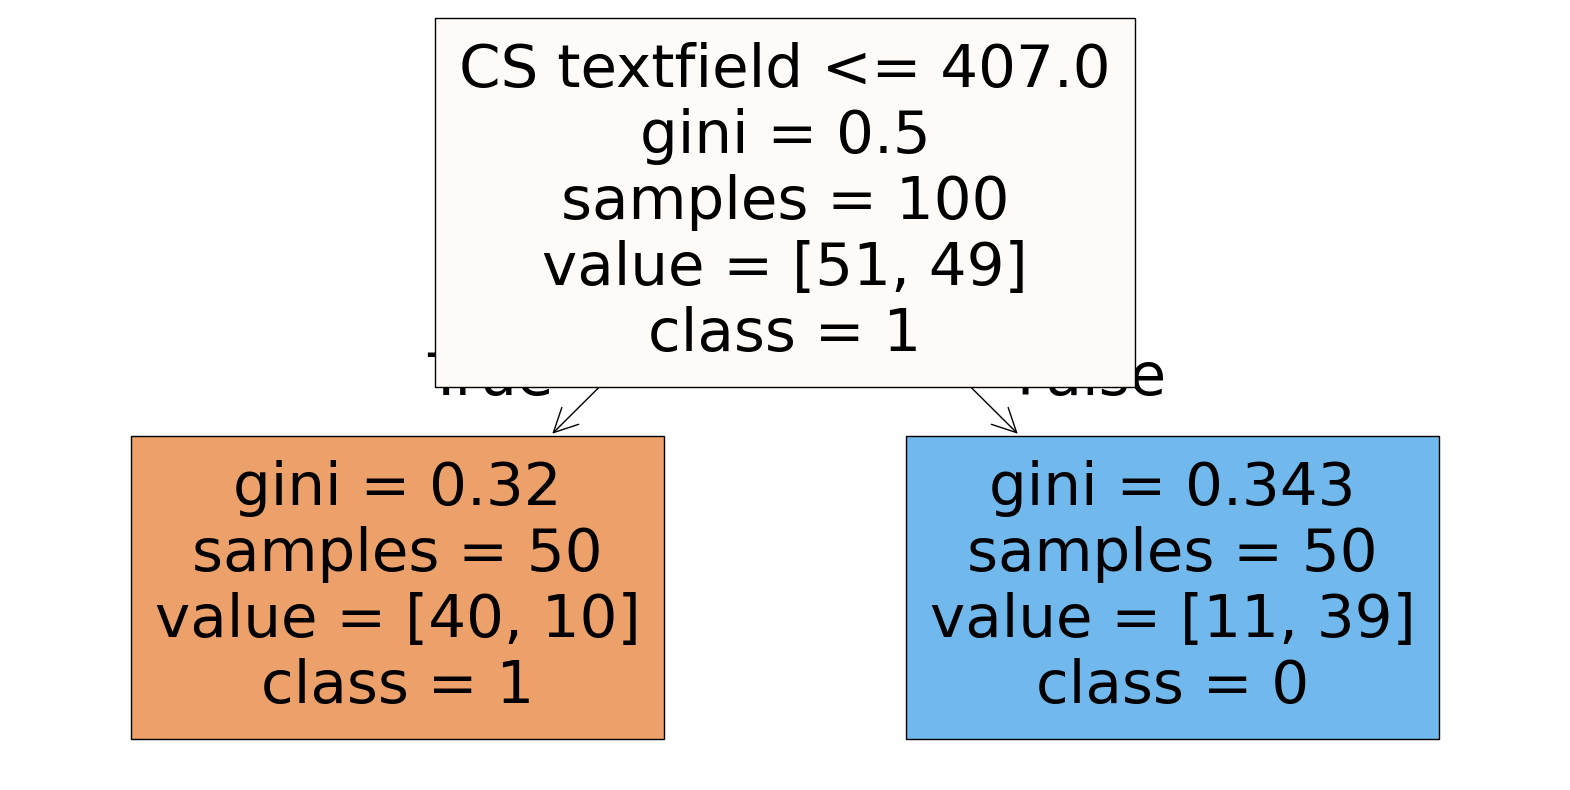

In [67]:
# Initialize variables
max_depth = 20
best_depth = -np.inf
best_acc = -np.inf
final_model = None
scores_arr = []

# Loop through depths from 1 to max_depth
for i in range(1, max_depth + 1):
    model = DecisionTreeClassifier(max_depth=i, random_state=42)
    
    # Perform cross-validation (5-fold CV)
    scores = cross_val_score(model, X, y, cv=5) 
    mean_acc = np.mean(scores)
    scores_arr.append(mean_acc)
    
    # Track the best model and depth
    if mean_acc > best_acc:
        best_depth = i
        best_acc = mean_acc
        final_model = DecisionTreeClassifier(max_depth=i, random_state=42)  # Re-initialize the model for fitting later

# Print the best accuracy and best depth
print(f"Best Accuracy: {best_acc}")
print(f"Best Depth: {best_depth}")

# Fit the final model on the full dataset
final_model.fit(X, y)  # Assuming X is the feature set and y is the target

# Predict using the final model on the same dataset (could be test data too if available)
y_pred = final_model.predict(X)

# Calculate and print the accuracy on the entire dataset
accuracy = accuracy_score(y, y_pred)
print(f"Final Model Accuracy on Full Data: {accuracy}")

# Export the decision tree rules as text
tree_rules = export_text(final_model, feature_names=X.columns.tolist())
print("Decision Tree Rules:")
print(tree_rules)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X.columns, class_names=[str(i) for i in y.unique()], filled=True)
plt.show()

## Splitting hyperplanes with SVM

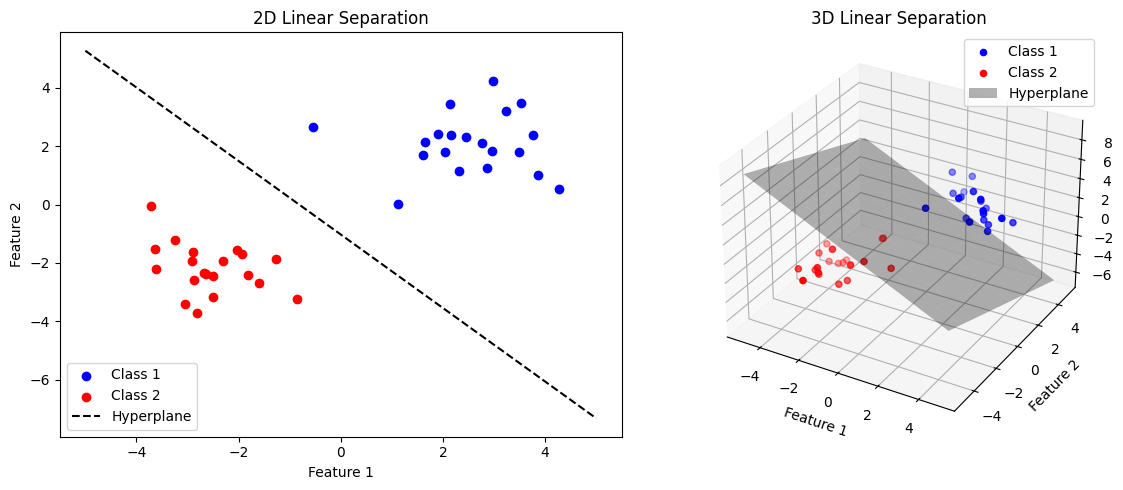

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC

# Generate 2D Data
np.random.seed(0)
class_1_2d = np.random.randn(20, 2) + np.array([2, 2])
class_2_2d = np.random.randn(20, 2) + np.array([-2, -2])

# Generate 3D Data
class_1_3d = np.random.randn(20, 3) + np.array([2, 2, 2])
class_2_3d = np.random.randn(20, 3) + np.array([-2, -2, -2])

# Concatenate data and labels
X_2d = np.vstack((class_1_2d, class_2_2d))
y_2d = np.hstack((np.ones(20), -1 * np.ones(20)))

X_3d = np.vstack((class_1_3d, class_2_3d))
y_3d = np.hstack((np.ones(20), -1 * np.ones(20)))

# Fit SVM models to find hyperplanes
svm_2d = SVC(kernel='linear')
svm_2d.fit(X_2d, y_2d)

svm_3d = SVC(kernel='linear')
svm_3d.fit(X_3d, y_3d)

# 2D Plot
plt.figure(figsize=(12, 5))

# Plot 2D data with decision boundary
plt.subplot(1, 2, 1)
plt.scatter(class_1_2d[:, 0], class_1_2d[:, 1], color='blue', label='Class 1')
plt.scatter(class_2_2d[:, 0], class_2_2d[:, 1], color='red', label='Class 2')

# Get the separating line
w = svm_2d.coef_[0]
slope = -w[0] / w[1]
intercept = -svm_2d.intercept_[0] / w[1]
x_vals = np.linspace(-5, 5, 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, 'k--', label='Hyperplane')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("2D Linear Separation")

# 3D Plot
ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter(class_1_3d[:, 0], class_1_3d[:, 1], class_1_3d[:, 2], color='blue', label='Class 1')
ax.scatter(class_2_3d[:, 0], class_2_3d[:, 1], class_2_3d[:, 2], color='red', label='Class 2')

# Create a mesh grid for the separating plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 10), np.linspace(-5, 5, 10))
z_vals = (-svm_3d.coef_[0][0] * xx - svm_3d.coef_[0][1] * yy - svm_3d.intercept_[0]) / svm_3d.coef_[0][2]
ax.plot_surface(xx, yy, z_vals, color='k', alpha=0.3, label='Hyperplane')

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.title("3D Linear Separation")
plt.legend()

plt.tight_layout()
plt.show()


### Pairs of features

In [7]:
X_train[['CS textfield', 'Saddle height']]

CS textfield  Saddle height
bid                              
1210        395.00          795.0
3962        405.00          740.0
2839        440.00          730.0
4249        425.00          718.0
2635        420.61          718.0
...            ...            ...
1461        392.90          786.0
2738        415.39          720.0
1268        380.00          480.0
4105        381.00          700.0
433         430.00          786.0

[80 rows x 2 columns]

In [18]:
import itertools
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed


def evaluate_model( feature_pair, kernel):
    X_feature = X_train[list(feature_pair)]  # Select the feature pair
    clf = SVC(kernel=kernel, max_iter=1000000)
    
    # Perform cross-validation and return the mean accuracy
    scores = cross_val_score(clf, X_feature, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    mean_accuracy = scores.mean()
    
    return {
        'features': feature_pair,
        'kernel': kernel,
        'accuracy': mean_accuracy,
    }

def p():

    results = []

    # List of kernels to evaluate
    kernels = ['linear', 'poly']

    # Create a list of tasks for all combinations of feature pairs and kernels
    tasks = [
        (feature_pair, kernel)
        for feature_pair in itertools.combinations(X_train.columns, 2)
        for kernel in kernels
    ]

    # Use joblib to parallelize the evaluation of models
    results = Parallel(n_jobs=-1)(delayed(evaluate_model)(feature_pair, kernel) for feature_pair, kernel in tasks)

    # Convert results to DataFrame and sort by accuracy
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='accuracy', ascending=False)

    return results_df.sort_values(by='accuracy', ascending=False)

if __name__ == '__main__':
    svm_pair_results = p()

print(svm_pair_results)



                                    features  kernel  accuracy
1065           (CS textfield, Saddle height)    poly    0.8875
1066           (CS textfield, Saddle length)  linear    0.8500
1263              (DT Length, Saddle height)    poly    0.8250
1067           (CS textfield, Saddle length)    poly    0.8250
1102                     (CS textfield, csd)  linear    0.8125
...                                      ...     ...       ...
3029    (SEATSTAYbrdgshift, Seatpost LENGTH)    poly    0.4125
2030  (Front Fender include, Head tube type)  linear    0.4125
272     (BB textfield, Front Fender include)  linear    0.4000
292      (BB textfield, Rear Fender include)  linear    0.4000
3209        (Saddle length, Seatpost LENGTH)    poly    0.3750

[3660 rows x 3 columns]


In [19]:
top_10 = svm_pair_results.head(10)

# Extract the feature pairs and flatten them
feature_pairs = top_10['features']
unique_features = set([feature for pair in feature_pairs for feature in pair])

# Display the unique features in the top 10
print(unique_features)

{'Head angle', 'Saddle height', 'CS textfield', 'csd', 'Saddle length', 'SBLADEW front', 'DT Length', 'Head tube diameter', 'Wheel width rear', 'Seat angle', 'SBLADEW rear'}


In [125]:
import itertools
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

def evaluate_model(X_train, y_train, feature_pair, kernel, feature_include):
    features = list(feature_pair) + [feature_include]
    X_feature = X_train[features]  
    clf = SVC(kernel=kernel, max_iter=1000000)
    
    # Perform cross-validation and return the mean accuracy
    scores = cross_val_score(clf, X_feature, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    mean_accuracy = scores.mean()
    
    return {
        'features': features,
        'kernel': kernel,
        'accuracy': mean_accuracy,
    }

def p(X_train, y_train):

    results = []

    # List of kernels to evaluate
    kernels = ['linear', 'poly', 'rbf']
    features_include = 'CS textfield'  # Assuming 'CS textfield' is a column name
    # Create a list of tasks for all combinations of feature pairs and kernels
    tasks = [
        (feature_pair, kernel, features_include)
        for feature_pair in itertools.combinations(X_train.columns, 2)
        if features_include not in feature_pair
        for kernel in kernels
    ]

    # Use joblib to parallelize the evaluation of models
    results = Parallel(n_jobs=-1)(delayed(evaluate_model)(X_train, y_train, feature_pair, kernel, features_include) for feature_pair, kernel, features_include in tasks)

    # Convert results to DataFrame and sort by accuracy
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='accuracy', ascending=False)

    return results_df.sort_values(by='accuracy', ascending=False)

if __name__ == '__main__':
    # Assuming X_train and y_train are already defined
    svm_three_results = p(X_train, y_train)

    print(svm_three_results)


                                           features kernel  accuracy
4573           [Saddle height, Stack, CS textfield]   poly    0.9000
787        [BSD front, Saddle height, CS textfield]   poly    0.8875
949         [BSD rear, Saddle height, CS textfield]   poly    0.8875
4591       [Saddle height, Wheel cut, CS textfield]   poly    0.8875
4024   [SBLADEW front, Saddle height, CS textfield]   poly    0.8750
...                                             ...    ...       ...
5222                 [Wheel cut, ssd, CS textfield]    rbf    0.5500
326            [BB length, Wheel cut, CS textfield]    rbf    0.5500
5051           [Stem kind, Wheel cut, CS textfield]    rbf    0.5500
3287  [Head tube diameter, Wheel cut, CS textfield]    rbf    0.5500
5225                 [Wheel cut, ttd, CS textfield]    rbf    0.5500

[5310 rows x 3 columns]


In [128]:
import itertools
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

# Define function to evaluate model for a given feature set
def evaluate_model(features, kernel):
    X_feature = X_train[features]
    clf = SVC(kernel=kernel, max_iter=1000000)
    scores = cross_val_score(clf, X_feature, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()
    return mean_accuracy

def greedy_feature_selection(max_features=10):
    # Starting with initial feature set
    best_features = ['CS textfield', 'Saddle height']
    best_accuracy = 0
    kernels = [ 'poly']
    features_to_evaluate = set(X_train.columns) - set(best_features)
    
    while len(best_features) < max_features:
        # Prepare tasks to evaluate feature pairs excluding current features
        tasks = [
            (list(best_features + [f1]), kernel)
            for f1 in features_to_evaluate
            for kernel in kernels
        ]
        
        # Evaluate all feature combinations in parallel
        results = Parallel(n_jobs=-1)(
            delayed(lambda fs, k: (fs, k, evaluate_model(fs, k)))(fs, k)
            for fs, k in tasks
        )
        
        # Find best result in this iteration
        best_result = max(results, key=lambda x: x[2])  # (features, kernel, accuracy)
        best_feature_pair, best_kernel, best_accuracy_iter = best_result
        
        if best_accuracy_iter > best_accuracy:
            # Update best accuracy and feature list
            best_accuracy = best_accuracy_iter
            best_features = best_feature_pair
            # Remove added features from future evaluations
            features_to_evaluate -= set(best_feature_pair)
        else:
            # Stop if no improvement
            break

    # Return final feature set and best accuracy achieved
    return best_features, best_accuracy

if __name__ == '__main__':
    selected_features, highest_accuracy = greedy_feature_selection()
    print(f"Best feature list: {selected_features}")
    print(f"Highest accuracy: {highest_accuracy}")


Best feature list: ['CS textfield', 'Saddle height', 'Stack']
Highest accuracy: 0.9


In [62]:
np.save('X_train.npy', X_feature)
np.save('y_train.npy', y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

features = ['Saddle height', 'Stack', 'CS textfield']
X_feature = X_train[features].values  

# Set up the SVM with the polynomial kernel
svm_clf = SVC(kernel='poly')

# , 3, 4, 5
param_grid = {
    'C': [0.1, 1, 10, 50, 100],          # Regularization parameter
    'degree': [2],               # Degree of the polynomial kernel
    'coef0': [0, 0.1, 0.5, 1, 10],        # Independent term in the polynomial kernel
    'gamma': [ 'scale']            
}

if __name__ == '__main__':
    grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X_feature, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Accuracy:", best_score)


Best Parameters: {'C': 0.1, 'coef0': 1, 'degree': 4, 'gamma': 'scale'}
Best Cross-Validation Accuracy: 0.9


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

features = ['Saddle height', 'Stack', 'CS textfield']
X_feature = X_train[features].values  

# Set up the SVM with the polynomial kernel
svm_clf = SVC(kernel='poly')

# , 3, 4, 5
param_grid = {
    'C': [0.1, 1, 10, 50, 100],          # Regularization parameter
    'degree': [2],               # Degree of the polynomial kernel
    'coef0': [0, 0.1, 0.5, 1, 10],        # Independent term in the polynomial kernel
    'gamma': [ 'scale']            
}

if __name__ == '__main__':
    grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X_feature, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Accuracy:", best_score)


Best Parameters: {'C': 100, 'coef0': 10, 'degree': 2, 'gamma': 'scale'}
Best Cross-Validation Accuracy: 0.9


In [ ]:
# All features

X_feature = X_train.values  

# Set up the SVM with the polynomial kernel
svm_clf = SVC(kernel='poly')

param_grid = {
    'C': [0.1, 1, 10, 50, 100],          # Regularization parameter
    'degree': [2, 3,3,4,5,6,7,8,9,10],               # Degree of the polynomial kernel
    'coef0': [0.1, 1, 10],        # Independent term in the polynomial kernel
    'gamma': [ 'scale']            
}

if __name__ == '__main__':
    grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X_feature, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Accuracy:", best_score)


Best Parameters: {'C': 1, 'coef0': 0.1, 'degree': 10, 'gamma': 'scale'}
Best Cross-Validation Accuracy: 0.8375


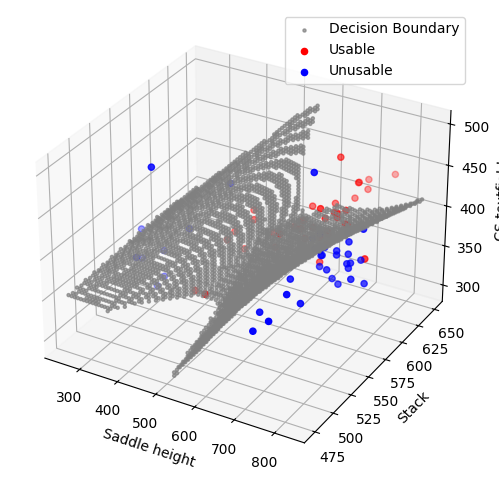

0.9
0.95


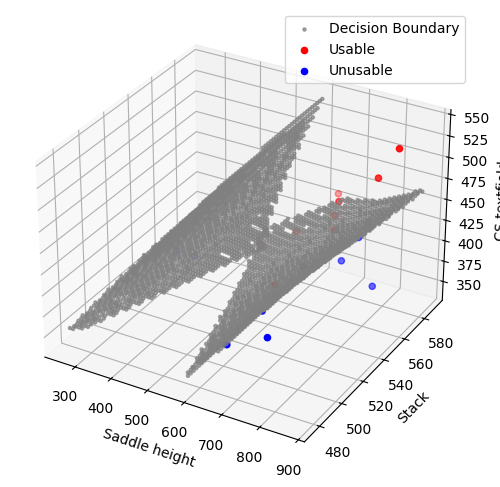

In [23]:
from importlib import reload  # Open this file to create interactive plot
import plots
reload(plots)

features = ['Saddle height', 'Stack', 'CS textfield']
X_feature = X_train[features].values  
svm_clf = SVC(kernel='poly',C = 100, coef0 = 10, degree= 2, gamma=  'scale')
# svm_clf = SVC(kernel='poly', degree=3, C= 50)
svm_clf.fit(X_feature, y_train)  

plots.plot_hyperplane_with_points(svm_clf,X_feature, y_train, features )

y_pred = svm_clf.predict(X_feature)
print(accuracy_score(y_train, y_pred))


X_feature = X_test[features].values  

y_pred = svm_clf.predict(X_feature)

print(accuracy_score(y_test, y_pred))
plots.plot_hyperplane_with_points(svm_clf,X_feature, y_test, features )


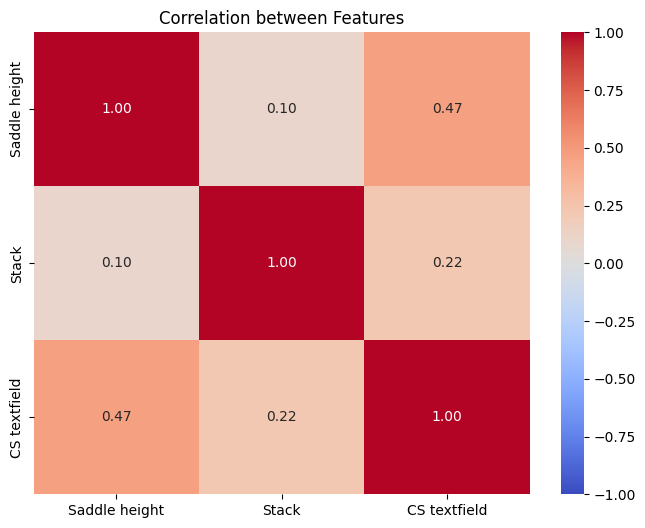

In [26]:
X_feature = X_train[features]

# Calculate the correlation matrix
correlation_matrix = X_feature.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation between Features')
plt.show()

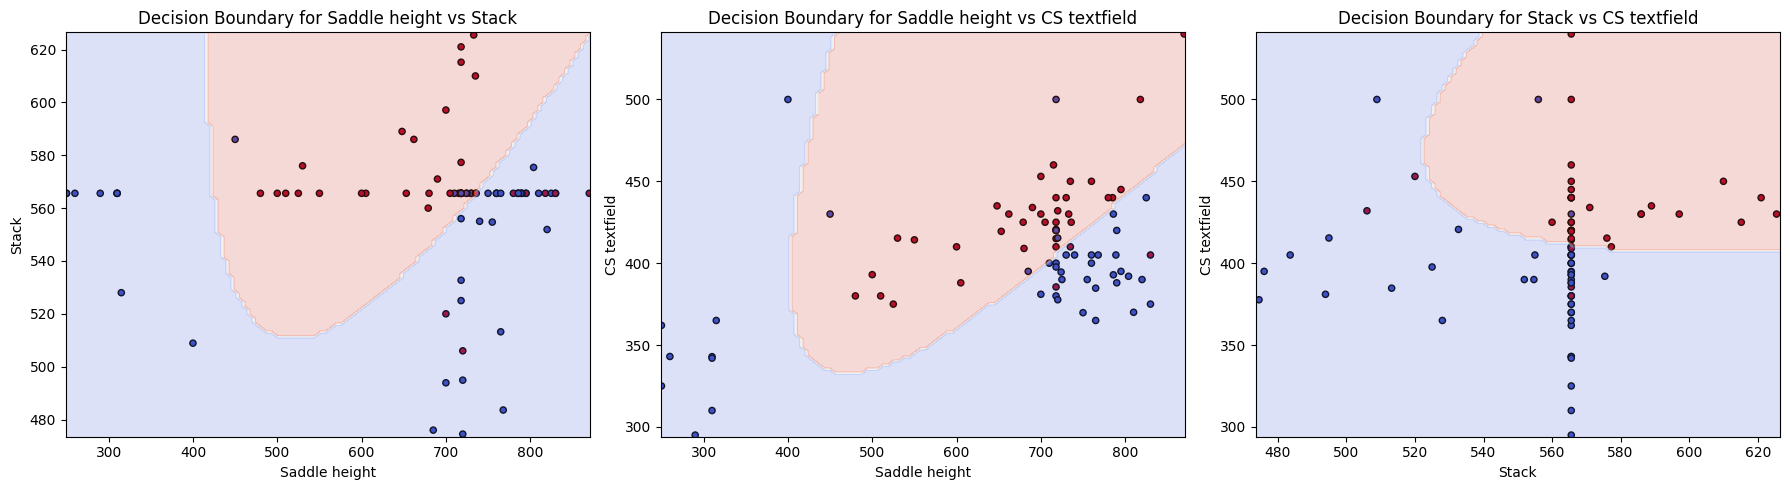

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from itertools import combinations

# Define feature pairs
features = ['Saddle height', 'Stack', 'CS textfield']
feature_pairs = list(combinations(features, 2))

# Initialize subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Loop over each pair of features
for i, (feat1, feat2) in enumerate(feature_pairs):
    X_feature = X_train[[feat1, feat2]].values
    
    # Train SVM classifier on the feature pair
    svm_clf = SVC(kernel='poly', degree=3)
    svm_clf.fit(X_feature, y_train)
    
    # Plot the data points
    ax = axs[i]
    ax.scatter(X_feature[:, 0], X_feature[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', s=20)
    
    # Create a grid to plot the decision boundary
    x_min, x_max = X_feature[:, 0].min() - 1, X_feature[:, 0].max() + 1
    y_min, y_max = X_feature[:, 1].min() - 1, X_feature[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    # Predict on grid and plot decision boundary
    Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
    
    # Set plot title and labels
    ax.set_title(f'Decision Boundary for {feat1} vs {feat2}')
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)

plt.tight_layout()
plt.show()


## Logistic Regression: No interacting terms


In [33]:
param_grid = {
    'logistic__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],  # Regularization strength
    'logistic__solver': ['liblinear', 'newton-cg', 'lbfgs'],  # Solvers
}

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('logistic', LogisticRegression(max_iter=5000))  # Logistic Regression
])

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search_lr.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_lr.best_score_:.4f}")

# Optionally, you can also get the best model and use it for predictions
best_model_lr = grid_search_lr.best_estimator_

# Get the coefficients from the best logistic regression model
coefficients = best_model_lr.named_steps['logistic'].coef_[0]

# Get the feature names directly from the input features
feature_names = X.columns  # Since we're not using PolynomialFeatures

# Create a DataFrame to view coefficients and feature names
feature_importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# Get the top 10 features
top_10_features = feature_importance.head(10)

# Construct the equation
equation = "logit(p) = "

# Add each term to the equation
for feature, coef in top_10_features.items():
    if coef > 0:
        equation += f" + {coef:.3f} * {feature}"
    else:
        equation += f" - {-coef:.3f} * {feature}"

print(equation)

Best parameters: {'logistic__C': 1e-05, 'logistic__solver': 'liblinear'}
Best cross-validation accuracy: 0.8125
logit(p) =  + 0.000 * Number of cogs + 0.000 * CS textfield + 0.000 * Dropout spacing + 0.000 * SBLADEW front + 0.000 * Display RACK + 0.000 * Stack + 0.000 * Wheel width rear + 0.000 * Number of chainrings + 0.000 * Wheel width front + 0.000 * SBLADEW rear


### Logistic Regression: With interacting terms


In [ ]:
def parallel_search():
    # Define the parameter grid
    param_grid = {
        'poly__degree': [2, 3, 4],  # Polynomial degrees
        'logistic__C': [ 1e-4, 1e-3,1e-2, 0.1, 1],  # Regularization strength
        'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear']  # Optimization algorithm
    }

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),  # Add polynomial features
        ('logistic', LogisticRegression(max_iter=5000))
    ])

    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on the entire dataset X and y
    grid_search.fit(X_train, y_train)  # Use the full dataset for cross-validation

    # Print best parameters and best score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Optionally fit the best model on the full dataset again (if desired)
    best_model.fit(X_train, y_train)  # Fit on the full dataset to use for predictions


    coefficients = best_model.named_steps['logistic'].coef_[0]

    # Get the feature names from PolynomialFeatures
    feature_names = best_model.named_steps['poly'].get_feature_names_out(X.columns)

    # Create a DataFrame to view coefficients and feature names
    feature_importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

    # Get the top 10 features
    top_10_features = feature_importance.head(10)

    # Construct the equation
    equation = "logit(p) = "

    # Add each term to the equation
    for feature, coef in top_10_features.items():
        if coef > 0:
            equation += f" + {coef:.3f} * {feature}"
        else:
            equation += f" - {-coef:.3f} * {feature}"

    print(equation)


if __name__ == "__main__":
    parallel_search()


#  cubic terms by themselves do not represent interactions between features.

Best parameters: {'logistic__C': 0.0001, 'logistic__solver': 'liblinear', 'poly__degree': 3}
Best cross-validation accuracy: 0.8000
logit(p) =  + 0.005 * BB length^3 + 0.004 * Stem kind^3 + 0.003 * Wheel cut^3 + 0.003 * SEATSTAYbrdgshift^3 + 0.003 * Head tube upper extension2^3 + 0.003 * Number of chainrings^3 + 0.002 * Seat tube extension2^3 + 0.002 * Stack^3 + 0.002 * Number of chainrings ttd^2 + 0.002 * SEATSTAYbrdgdia1^2 Saddle height


Decision Tree Mean Accuracy at depth 1: 0.6200
Decision Tree Mean Accuracy at depth 2: 0.6900
Decision Tree Mean Accuracy at depth 3: 0.7500
Decision Tree Mean Accuracy at depth 4: 0.7000
Decision Tree Mean Accuracy at depth 5: 0.7000

Best Depth: 3 with Mean Accuracy: 0.7500


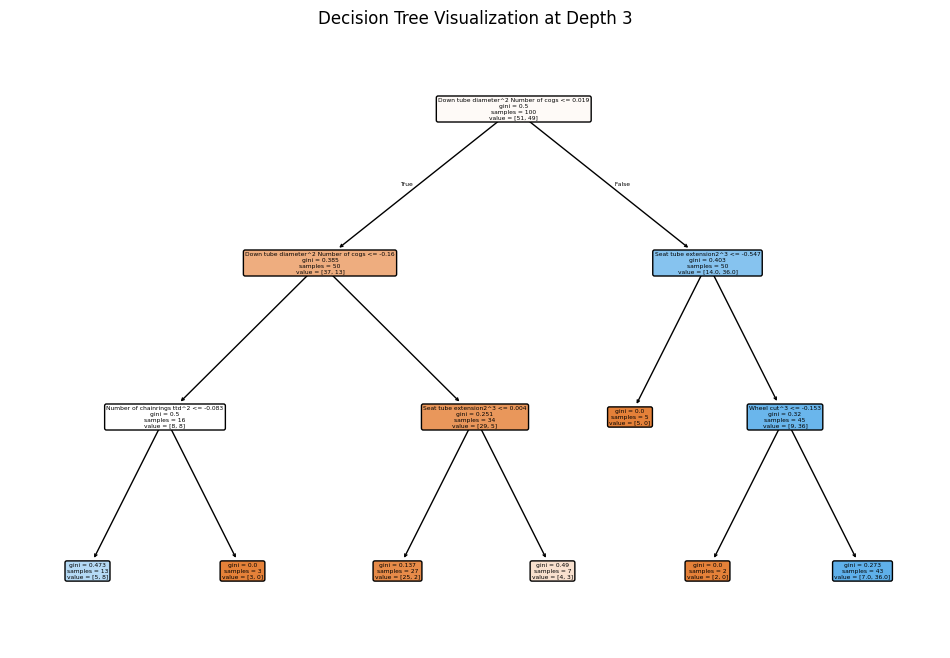

In [69]:

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (degree 3 based on best parameters)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_scaled)

# Initialize and train a logistic regression model with the best parameters
logistic_model = LogisticRegression(C=0.001, solver='liblinear', max_iter=5000)
logistic_model.fit(X_poly, y)

# Extract coefficients
coefficients = logistic_model.coef_[0]
feature_names = poly.get_feature_names_out(X.columns)

# Create a Series for feature importance and sort
feature_importance = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

# Get top features and their coefficients
top_features = feature_importance.head(10).index
top_coefficients = feature_importance.head(10).values

# Create a new DataFrame with top features only
X_top = pd.DataFrame(X_poly, columns=feature_names)[top_features]

# Loop through multiple tree depths and evaluate the model using cross-validation
best_accuracy = 0
best_depth = 0
best_tree_model = None

depths = range(1, 6)  # Example depths from 1 to 5
for depth in depths:
    # Train a decision tree model for the current depth
    tree_model = DecisionTreeClassifier(max_depth=depth)
    
    # Perform cross-validation
    cv_scores = cross_val_score(tree_model, X_top, y, cv=5, scoring='accuracy')
    
    # Calculate the mean accuracy from cross-validation
    mean_accuracy = cv_scores.mean()
    print(f"Decision Tree Mean Accuracy at depth {depth}: {mean_accuracy:.4f}")

    # Check for the best accuracy and save the model if it's the best
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_depth = depth
        best_tree_model = tree_model

# Output the best depth and accuracy
print(f"\nBest Depth: {best_depth} with Mean Accuracy: {best_accuracy:.4f}")

# Fit the best model on the full dataset for visualization
best_tree_model.fit(X_top, y)

# Visualize the best decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_tree_model, feature_names=top_features, filled=True, rounded=True)
plt.title(f"Decision Tree Visualization at Depth {best_depth}")
plt.show()

## Plots

In [32]:
def save_tree(tree, file_name):
    joblib.dump(tree, f'model weights/{file_name}.pkl')

def load_tree(file_name ):
    return joblib.load(f'{file_name}.pkl')

# Classification


In [35]:
def get_model_and_params(model_name, param_grid):
    if model_name == "rforest":
        model = RandomForestClassifier(random_state=123)
        param_grid.update({"randomforestclassifier__warm_start": [True, False],
                "randomforestclassifier__n_estimators": [100, 200],
                "randomforestclassifier__max_depth": range(2, 14),
                "randomforestclassifier__min_samples_leaf": range(2, 10),
                "randomforestclassifier__criterion":["gini", "entropy"]})
    elif model_name == "knn":
        model = KNeighborsClassifier()
        param_grid.update({"kneighborsclassifier__n_neighbors": range(2, 50),
                "kneighborsclassifier__weights": ["uniform", "distance"]})
    elif model_name == "dt":
        model = DecisionTreeClassifier(random_state=123)
        param_grid.update({"decisiontreeclassifier__max_depth": range(1, 14),
                "decisiontreeclassifier__min_samples_leaf": range(1, 12),
              "decisiontreeclassifier__min_samples_split": range(1, 40, 2),
                "decisiontreeclassifier__criterion":["gini", "entropy"]})
    elif model_name == "Ada":
        model = AdaBoostClassifier()
        param_grid.update({#"adaboostclassifiert__estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
                "adaboostclassifier__n_estimators": [50, 80],
                "adaboostclassifier__learning_rate": [0.5, 1.0, 1.5, 2.0, 2.5]})
    #elif model_name == "SVC": # runtime too long. Stopped after 2 hours 
    #    model = SVC()
    #    param_grid.update({"svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    #            "svc__class_weight": ["balanced", "None"]})
    elif model_name == "GaussPrC":
        model = GaussianProcessClassifier(1.0 * RBF(1.0))
        param_grid.update({"gaussianprocessclassifier__multi_class": ["one_vs_rest", "one_vs_one"]})
    elif model_name == "mlp":
        model = MLPClassifier()
        param_grid.update({"mlpclassifier__hidden_layer_sizes": [(200), (200, 200, 200)],
            "mlpclassifier__max_iter": [3000, 5000]})
    elif model_name == "lr":
        model = LogisticRegression()
        param_grid.update({
            'logisticregression__penalty': ['l1','l2'],  # Penalty norm
            'logisticregression__C': np.logspace(-4, 4, 20),  # Regularization parameter
            'logisticregression__solver': ['liblinear', 'saga'],  # Solver for logistic regression
            'logisticregression__tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criteria
            'logisticregression__warm_start': [True, False]

        })
    return model, param_grid


In [36]:
def evaluate_models(list_of_models, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "test_recall_score": [],
        "test_precision_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": [],
        "model_instance": [],
        "preds": [],
    }
    param_grid = {}
    
    for i in list_of_models:
        #reset values to be empty : 
        model = ""
        param_grid.clear()
        param_grid = param_grid_preproc

        # # # # it would nice if I make this into a function get_model_and_params
        model, param_grid = get_model_and_params(i, param_grid)

        #create the full_pipeline
        full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

        # define cross validation
        search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=10,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5,
                      random_state=123
                    )                             

        # fit
        search.fit(X_train, y_train)
        score_new['model_instance'].append(search.best_estimator_)

        score_new["model"].append(i)

        ### testing accuracy
        y_test_pred = search.predict(X_test)
        score_new["preds"].append(y_test_pred)
        print(len(y_test_pred))
        acc_test = accuracy_score(y_test, y_test_pred)
        score_new["test_acc_score"].append(acc_test)

        precision = precision_score(y_test, y_test_pred, average='weighted')
        score_new["test_precision_score"].append(precision)

        # Calculate recall
        recall = recall_score(y_test, y_test_pred, average='weighted')
        score_new["test_recall_score"].append(recall)

        #get score of TRAIN-Data (overfitting?)
        y_train_pred = search.predict(X_train)
        acc_train = accuracy_score(y_train, y_train_pred)
        score_new["train_acc_score"].append(acc_train)

        # keep scores of model (optional)
        score_new["best_score_of_CV"].append(search.best_score_)
        score_new["best_params"].append(search.best_params_)

        # confusion matrix
        conf = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                    display_labels=search.classes_)
        
        disp.plot()
        plt.xticks(rotation=90)

        plt.show()

        print(i, model)
        print(pd.DataFrame(conf))
        print("end")
    return pd.DataFrame(score_new)



In [37]:

def evaluate_models_with_cross_validation(list_of_models, X, y, preprocessor, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "test_precision_score": [],
        "test_recall_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": [],
        "model_instance": [],
        "preds": [],
    }

    for i in list_of_models:
        # Get the model and its parameter grid
        model, param_grid = get_model_and_params(i, param_grid_preproc.copy())

        # Create the full pipeline
        full_pipe = make_pipeline(preprocessor, 
                                  StandardScaler(with_mean=False),
                                  model)

        # Define and run cross-validation with hyperparameter search
        search = RandomizedSearchCV(full_pipe,
                                    param_grid,
                                    cv=5,
                                    verbose=1,
                                    scoring="accuracy",
                                    n_jobs=-1,  # Use all available cores
                                    n_iter=5,
                                    random_state=123)

        # Fit with cross-validation
        search.fit(X, y)

        # Save the best estimator and model name
        score_new['model_instance'].append(search.best_estimator_)
        score_new["model"].append(i)

        # Cross-validated predictions
        y_pred = cross_val_predict(search.best_estimator_, X, y, cv=5)
        score_new["preds"].append(y_pred)

        # Calculate test accuracy, precision, and recall
        score_new["test_acc_score"].append(accuracy_score(y, y_pred))
        score_new["test_precision_score"].append(precision_score(y, y_pred, average='weighted'))
        score_new["test_recall_score"].append(recall_score(y, y_pred, average='weighted'))

        # Calculate cross-validated accuracy on training data
        train_acc = cross_val_score(search.best_estimator_, X, y, cv=5, scoring='accuracy').mean()
        score_new["train_acc_score"].append(train_acc)

        # Store the best cross-validation score and parameters
        score_new["best_score_of_CV"].append(search.best_score_)
        score_new["best_params"].append(search.best_params_)

        # Confusion matrix
        conf = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=search.classes_)
        disp.plot()
        plt.xticks(rotation=90)
        plt.show()

        print(i, model)
        print(pd.DataFrame(conf))
        print("end")

    return pd.DataFrame(score_new)


In [ ]:
# y = meaningfull_bikes_df["usable"] 
# X = meaningfull_bikes_df.drop(columns=["usable"]) 

In [39]:
score_NN.to_csv('model_details.csv')


Fitting 5 folds for each of 5 candidates, totalling 25 fits


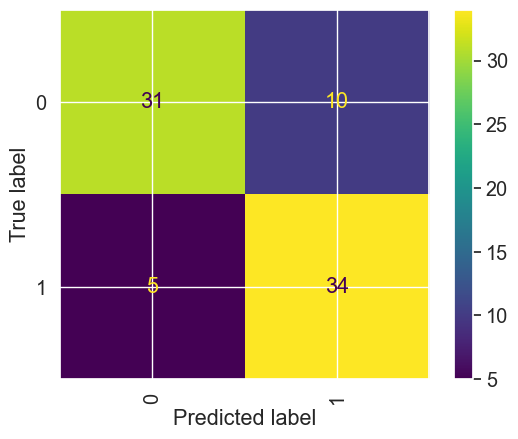

knn KNeighborsClassifier()
    0   1
0  31  10
1   5  34
end
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


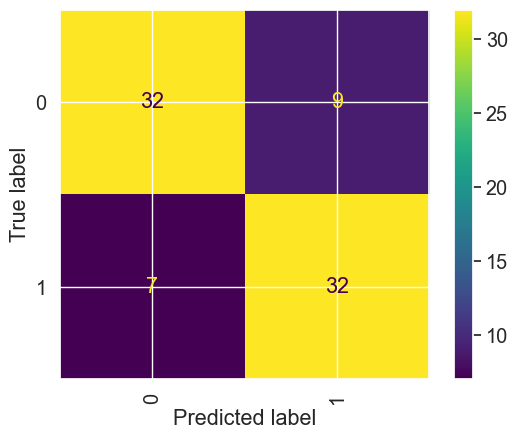

mlp MLPClassifier()
    0   1
0  32   9
1   7  32
end
Fitting 5 folds for each of 5 candidates, totalling 25 fits


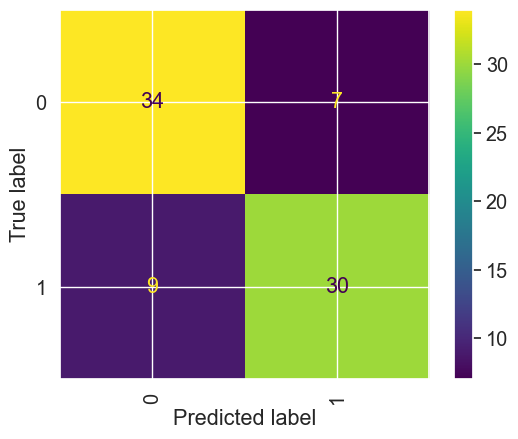

rforest RandomForestClassifier(random_state=123)
    0   1
0  34   7
1   9  30
end
Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\pipeline.py", line 4

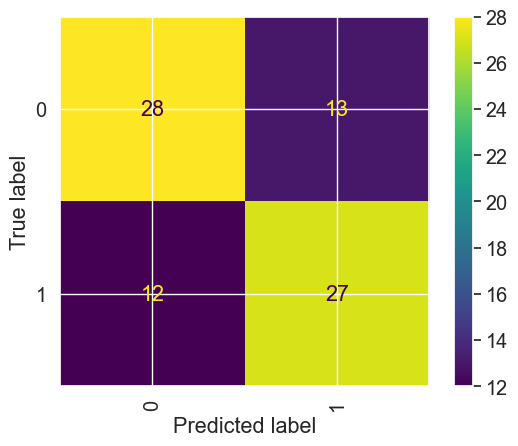

dt DecisionTreeClassifier(random_state=123)
    0   1
0  28  13
1  12  27
end
Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

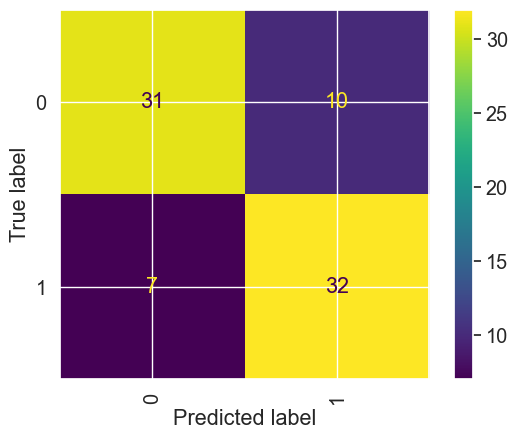

lr LogisticRegression()
    0   1
0  31  10
1   7  32
end


model  test_acc_score  test_precision_score  test_recall_score  \
0      knn          0.8125              0.818024             0.8125   
1      mlp          0.8000              0.801001             0.8000   
2  rforest          0.8000              0.800503             0.8000   
3       dt          0.6875              0.687813             0.6875   
4       lr          0.7875              0.789521             0.7875   

   train_acc_score  best_score_of_CV  \
0           0.8125            0.8125   
1           0.7625            0.8000   
2           0.8000            0.8000   
3           0.6875            0.6875   
4           0.7875            0.7875   

                                         best_params  \
0  {'kneighborsclassifier__weights': 'uniform', '...   
1  {'mlpclassifier__max_iter': 3000, 'mlpclassifi...   
2  {'randomforestclassifier__warm_start': True, '...   
3  {'decisiontreeclassifier__min_samples_split': ...   
4  {'logisticregression__warm_start': False, 'log...   

                                      model_instance  \
0  (ColumnTransformer(transformers=[('num_pipe',\...   
1  (ColumnTransformer(transformers=[('num_pipe',\...   
2  (ColumnTransformer(transformers=[('num_pipe',\...   
3  (ColumnTransformer(transformers=[('num_pipe',\...   
4  (ColumnTransformer(transformers=[('num_pipe',\...   

                                               preds  
0  [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...  
1  [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...  
2  [0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, ...  
3  [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...  
4  [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...

In [ ]:



numeric_pipe = make_pipeline(
    SimpleImputer(strategy="constant"),   #strategy="constant"
    MinMaxScaler()
)
X_num = X_train.select_dtypes(include="number").copy()
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        # ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

list_of_models = [ "knn","mlp", "rforest", "dt", 'lr']#

param_grid_preproc = {}
score_NN = evaluate_models_with_cross_validation(list_of_models,X_train,y_train,preprocessor, param_grid_preproc)

# score_NN = evaluate_models(list_of_models, param_grid_preproc)
score_NN.to_csv('model_details.csv')

In [12]:

y_all_pred = np.zeros(len(y_train))
# Define the number of folds
n_splits = 5

# Initialize variables for storing results
accuracy_scores = []
precision_scores = []
recall_scores = []
confusion_matrices = []

# Set up StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

# Loop through each fold
for train_index, test_index in skf.split(X_train, y_train):
    # Split data into train and test sets for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold.values, dtype=torch.float32)
    X_train_tensor.requires_grad = True

    X_test_tensor = torch.tensor(X_test_fold.values, dtype=torch.float32)
    X_test_tensor.requires_grad = False

    # Initialize the classifier
    classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=8, no_grad=False, no_preprocess_mode=True)

    # Fit the classifier on the training data
    classifier.fit(X_train_tensor, y_train_fold, overwrite_warning=True)

    # Make predictions on the test data
    with torch.no_grad():
        y_eval, _ = classifier.predict(X_test_tensor, return_winning_probability=True)

    # Store the predictions in the appropriate locations in y_all_pred
    y_all_pred[test_index] = y_eval

    # Calculate metrics
    accuracy = accuracy_score(y_test_fold, y_eval)
    precision = precision_score(y_test_fold, y_eval, average='binary')
    recall = recall_score(y_test_fold, y_eval, average='binary')
    
    # Calculate confusion matrix
    conf = confusion_matrix(y_test_fold, y_eval)
    
    # Store the results
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    confusion_matrices.append(conf)

    print(f"Fold results - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Calculate overall metrics for the entire dataset
overall_accuracy = accuracy_score(y_train, y_all_pred)
overall_precision = precision_score(y_train, y_all_pred, average='binary')
overall_recall = recall_score(y_train, y_all_pred, average='binary')
overall_confusion_matrix = confusion_matrix(y_train, y_all_pred)

# Print the overall metrics
print("\nOverall Results on Entire Dataset:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")

# Display the overall confusion matrix
print("\nOverall Confusion Matrix:")
print(overall_confusion_matrix)



c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Fold results - Accuracy: 0.9375, Precision: 0.8750, Recall: 1.0000


c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Fold results - Accuracy: 0.5000, Precision: 0.5000, Recall: 0.3750


c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Fold results - Accuracy: 0.8125, Precision: 0.7778, Recall: 0.8750


c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Fold results - Accuracy: 0.7500, Precision: 0.7500, Recall: 0.7500


c:\Users\fabie\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Fold results - Accuracy: 0.9375, Precision: 0.8889, Recall: 1.0000

Overall Results on Entire Dataset:
Accuracy: 0.7875
Precision: 0.7750
Recall: 0.7949

Overall Confusion Matrix:
[[32  9]
 [ 8 31]]


In [14]:
# classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=8, no_grad=False, no_preprocess_mode=True)
# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# X_train_tensor.requires_grad = True


# # Fit the classifier
# classifier.fit(X_train_tensor, y_train, overwrite_warning=True)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# X_test_tensor.requires_grad = False
# with torch.no_grad():
#     y_eval, p_eval = classifier.predict(X_test_tensor, return_winning_probability=True)


# accuracy = accuracy_score(y_test, y_eval)
# print('Accuracy:', accuracy)

# precision = precision_score(y_test, y_eval, average='binary')  # Use 'binary' for binary classification, 'macro' for multiclass
# print('Precision:', precision)

# recall = recall_score(y_test, y_eval, average='binary')  # Use 'binary' for binary classification, 'macro' for multiclass
# print('Recall:', recall)

# conf = confusion_matrix(y_test, y_eval)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf,
#                             display_labels=classifier.classes_)
# disp.plot()
# plt.xticks(rotation=90)
# plt.show()

